In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils import PSNR

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy

/home/aman.kukde/miniforge3/envs/fit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(22122020)

Seed set to 22122020


22122020

In [3]:
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data(subset_flag=False)
dm.setup()

In [4]:
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

In [5]:
n_heads = 8
d_query = 32

In [6]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='sum',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 4,
                              model_path ='')
import datetime

# Train your own model.
name = datetime.datetime.now().strftime("%d-%m_%H-%M-%S")
wandb_logger = WandbLogger(name = f'Run_{name}',project="MNIST",save_dir=f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}',log_model="all")
trainer = Trainer(max_epochs=100,logger=wandb_logger,
                  enable_checkpointing=True,default_root_dir = f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}', 
                                            callbacks=ModelCheckpoint(
                                            dirpath=f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}',
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            # mode='min'),limit_train_batches= 0.1,fast_dev_run=True)
                                            mode='min'))#,limit_train_batches= 0.1,fast_dev_run=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# trainer = Trainer(max_epochs=100, 
#                   gpus=1, # set to 0 if you want to run on CPU
#                   callbacks=ModelCheckpoint(
#                                             dirpath=None,
#                                             save_top_k=1,
#                                             verbose=False,
#                                             save_last=True,
#                                             monitor='Train/avg_val_loss',
#                                             mode='min'
#                                         ), 
#                   deterministic=True)

In [8]:
# Train your own model.
# trainer.fit(model, datamodule=dm);

In [9]:
# if not exists('./models/sres/mnist_sres.ckpt'):
#     wget.download('https://download.fht.org/jug/fit/sres_model_mnist.ckpt',
#                   out='./models/sres/mnist_sres.ckpt')

In [10]:
model.load_test_model('/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/21-02_18-10-24_sum_modified/last.ckpt')
# model.cpu();

weights loaded successfully


In [11]:
for fc, (mag_min, mag_max) in dm.train_dataloader():
    break

In [12]:
print(np.unique(mag_max), np.unique(mag_min))

[ 5.800053] [-2.7607348]


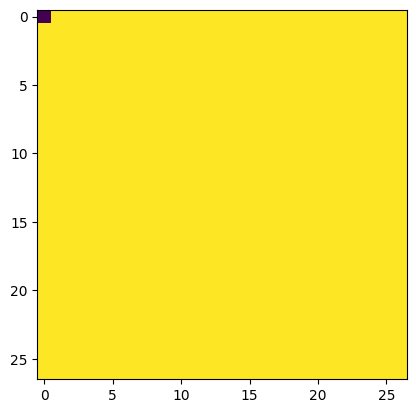

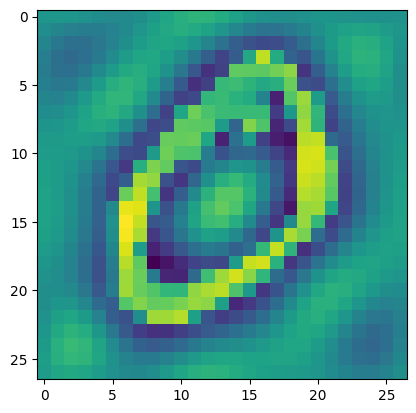

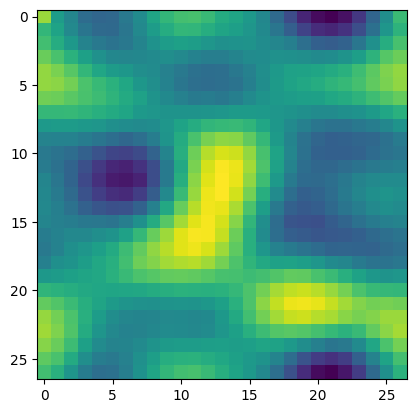

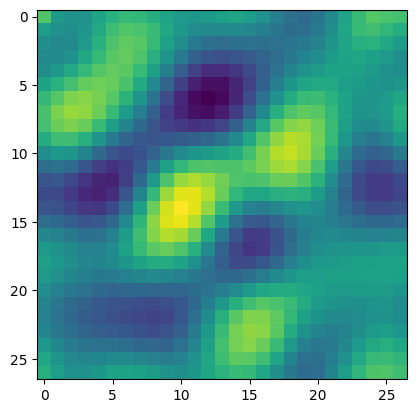

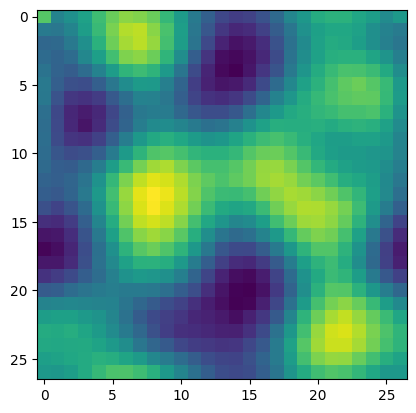

In [14]:
lowres, pred_img, gt = model.get_lowres_pred_gt(fc, mag_min, mag_max)

/tmp/ipykernel_62760/22062025.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(31/2., 10/2.))


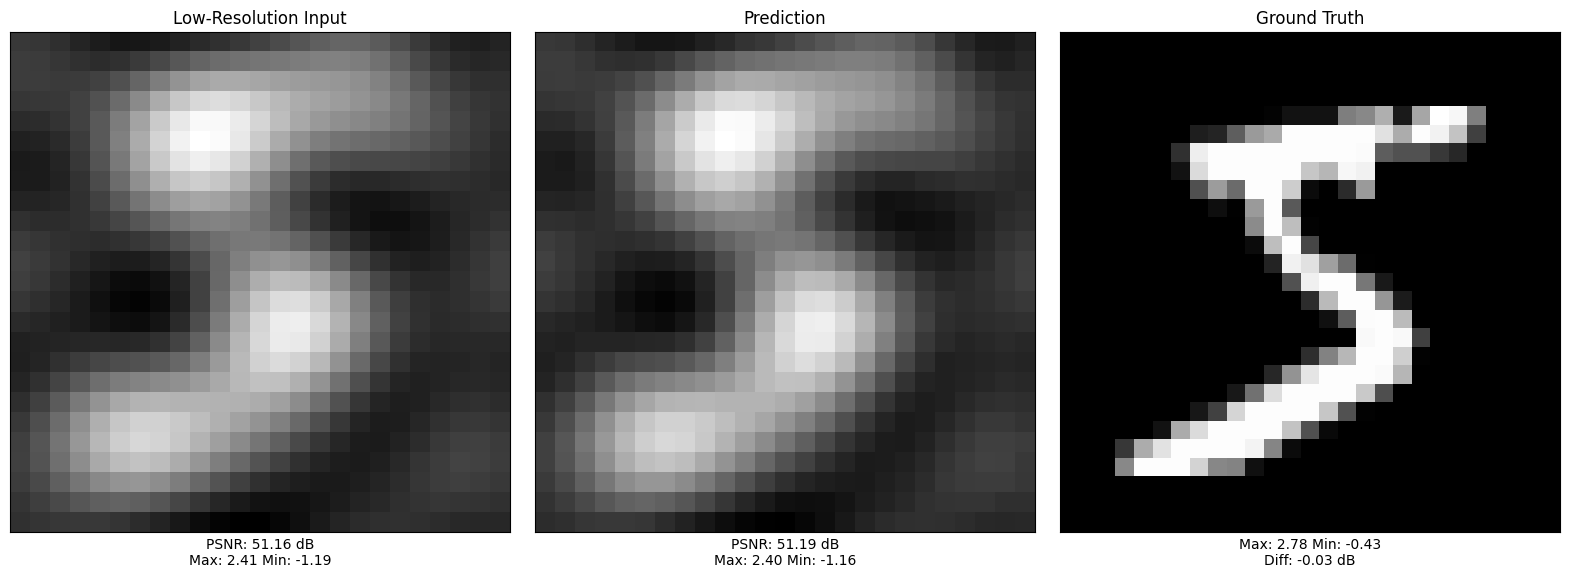

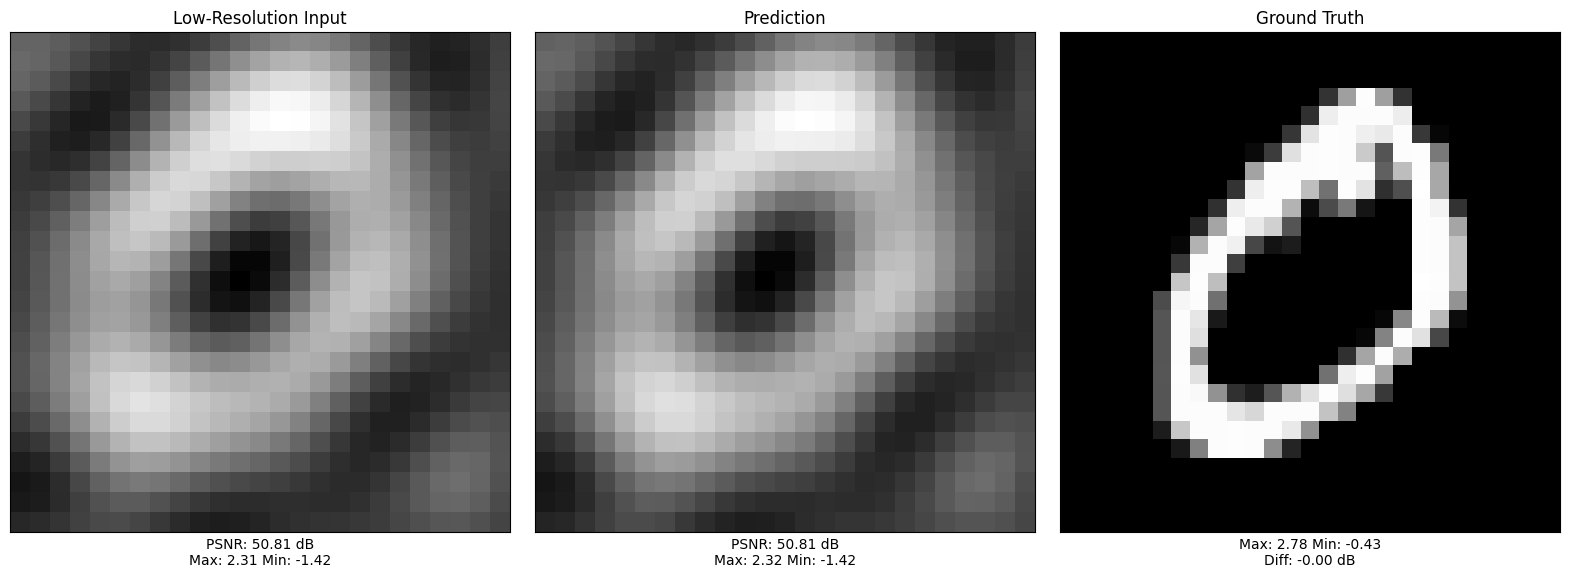

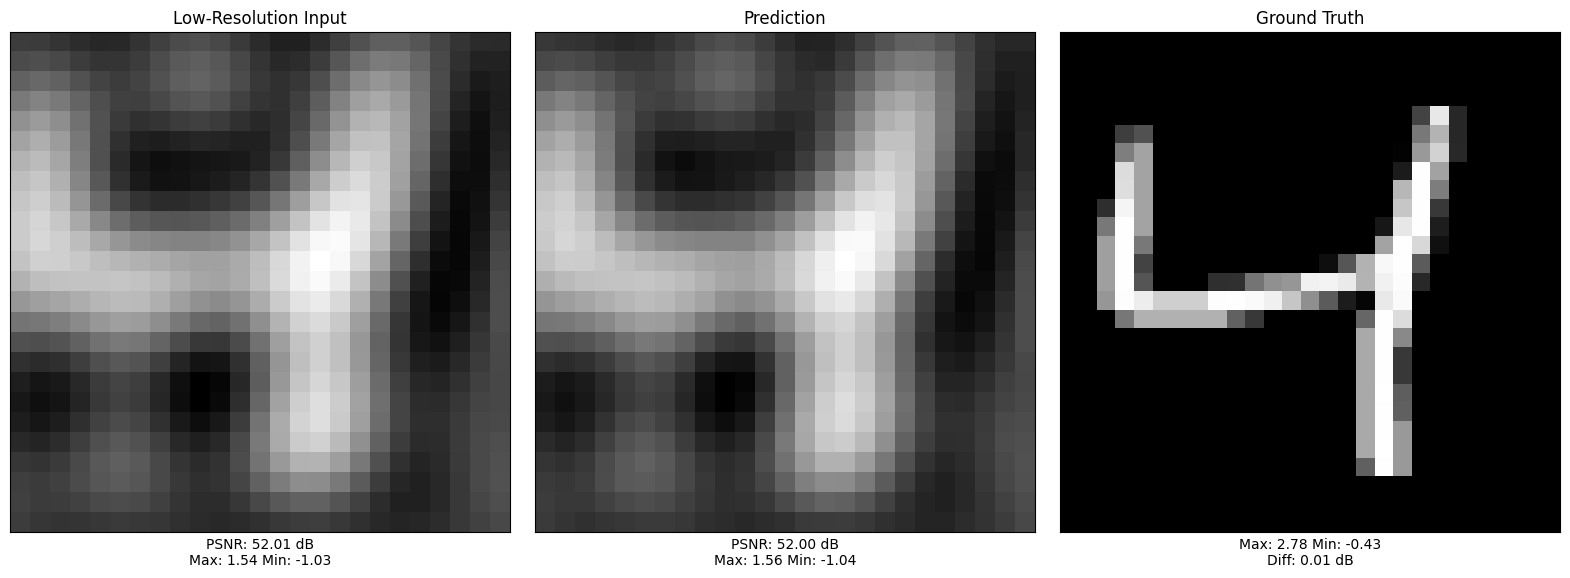

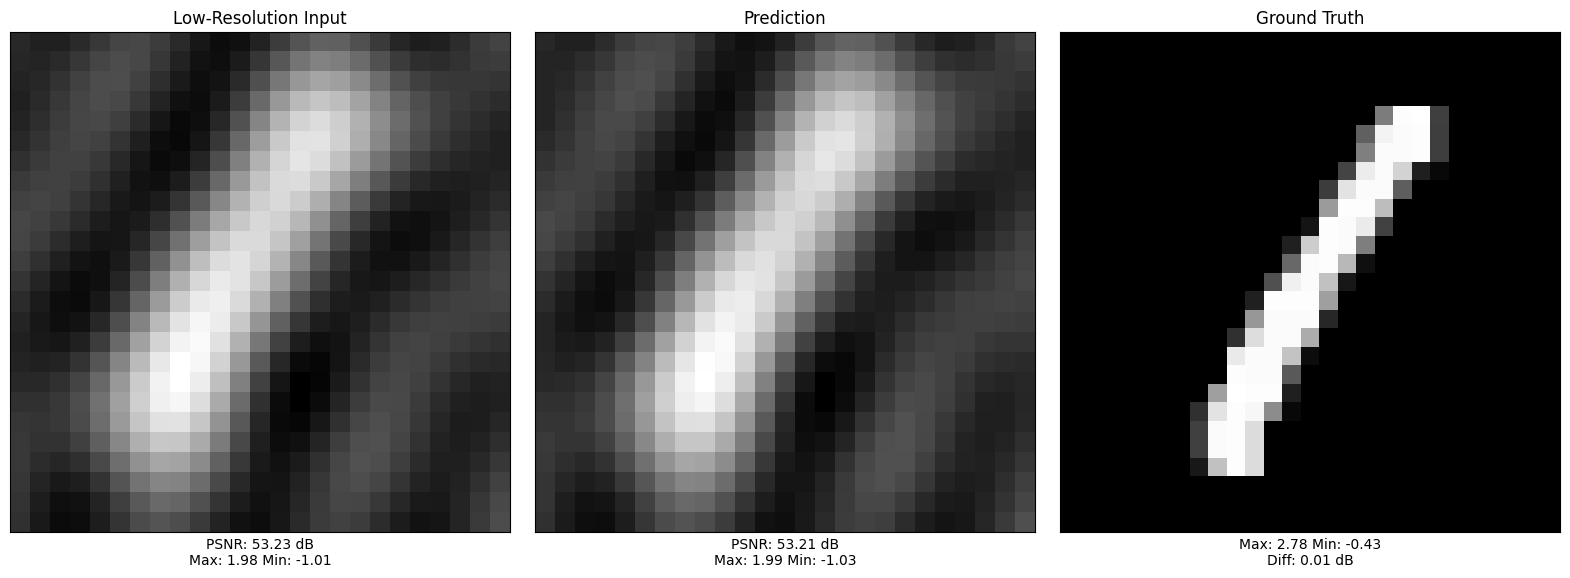

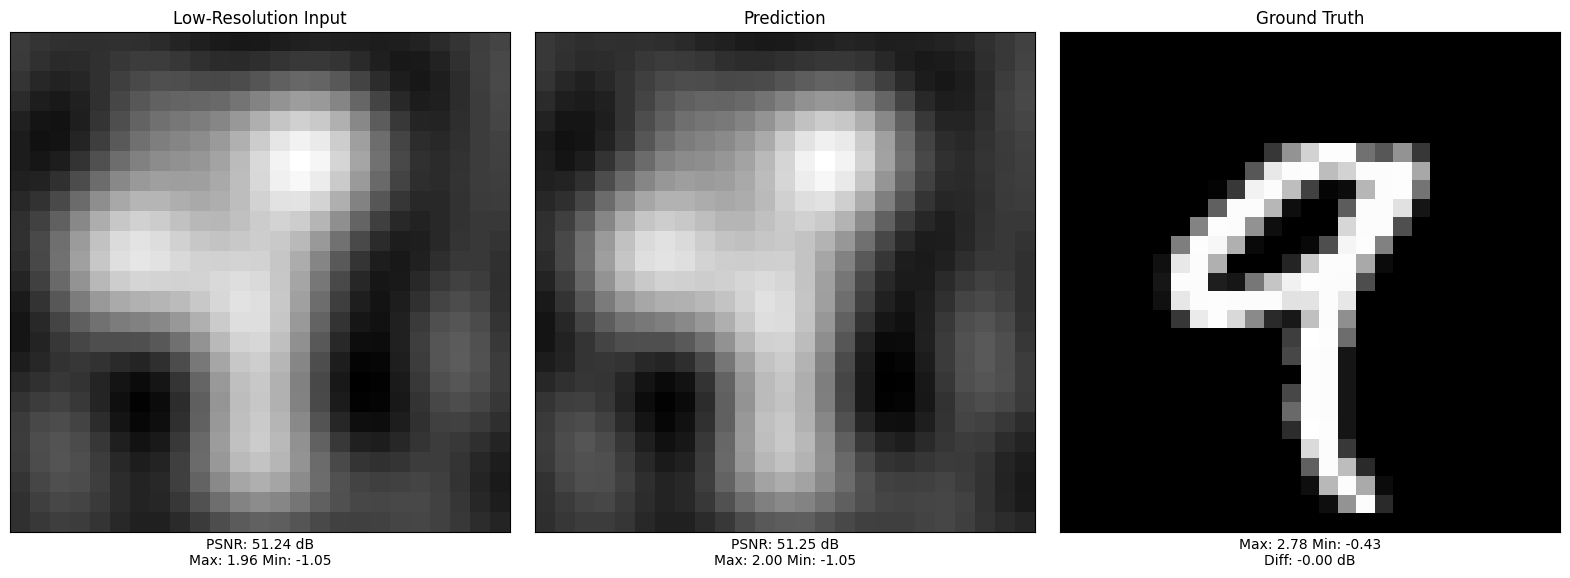

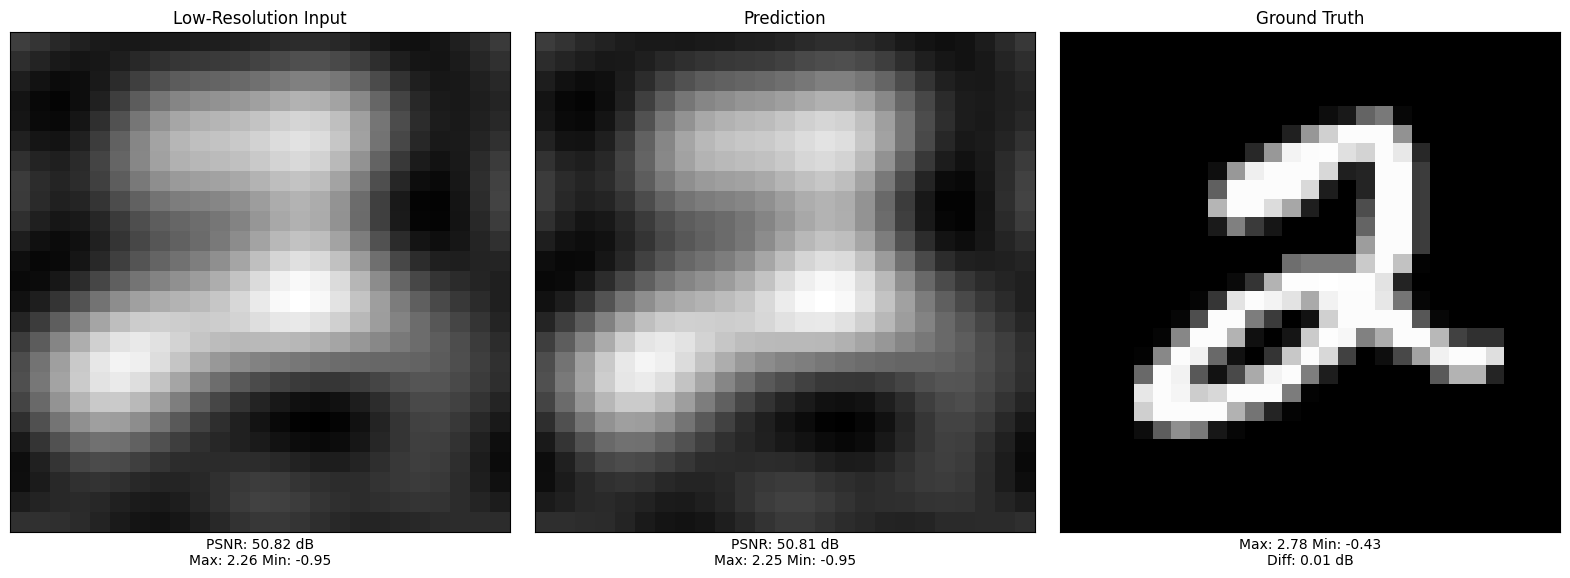

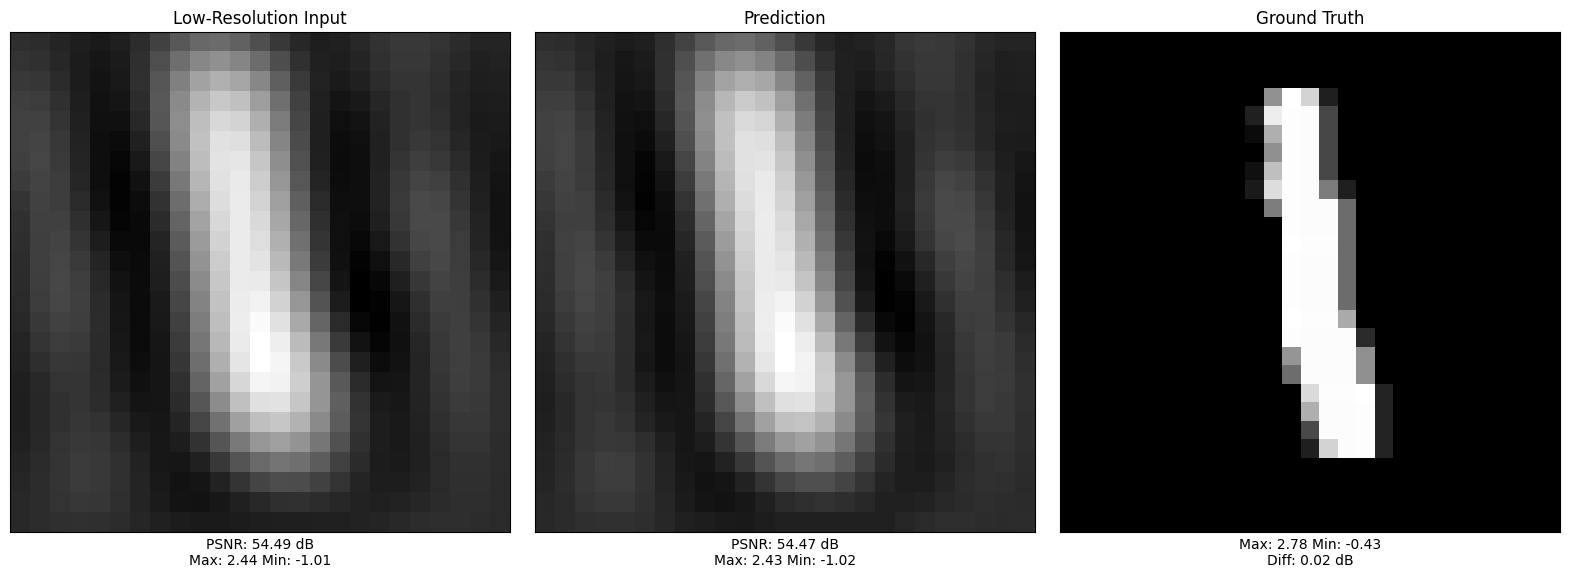

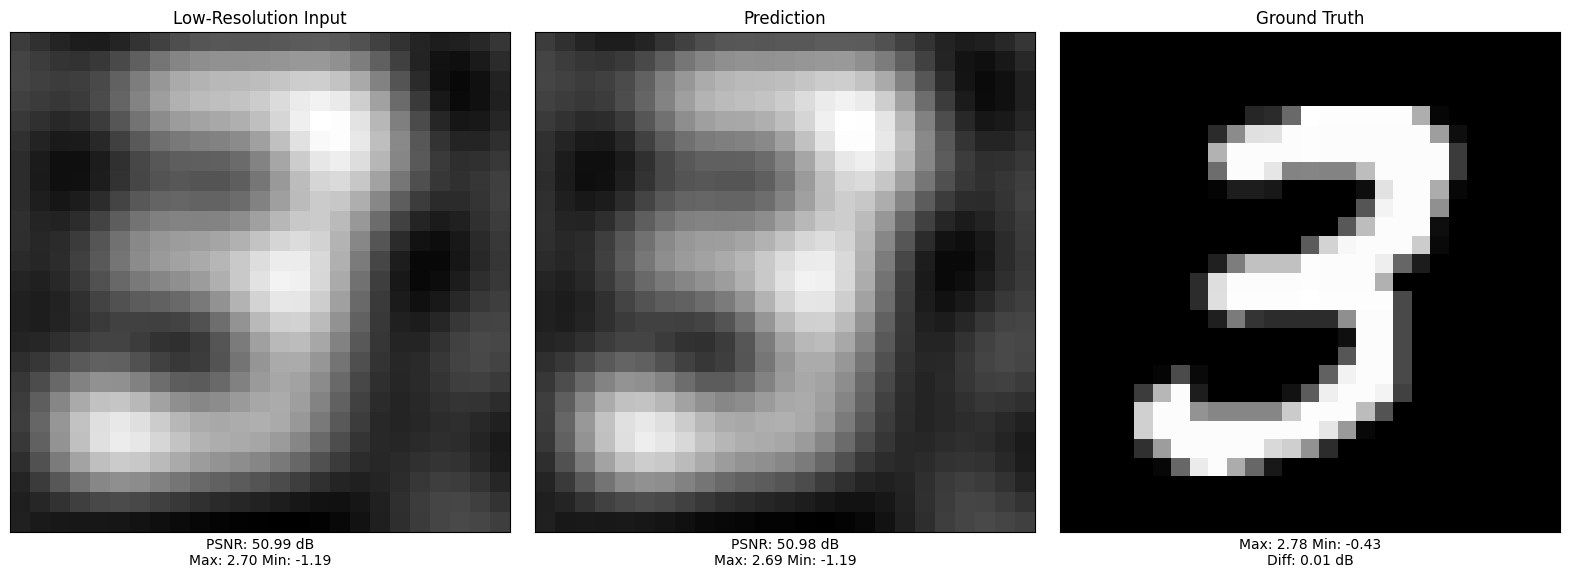

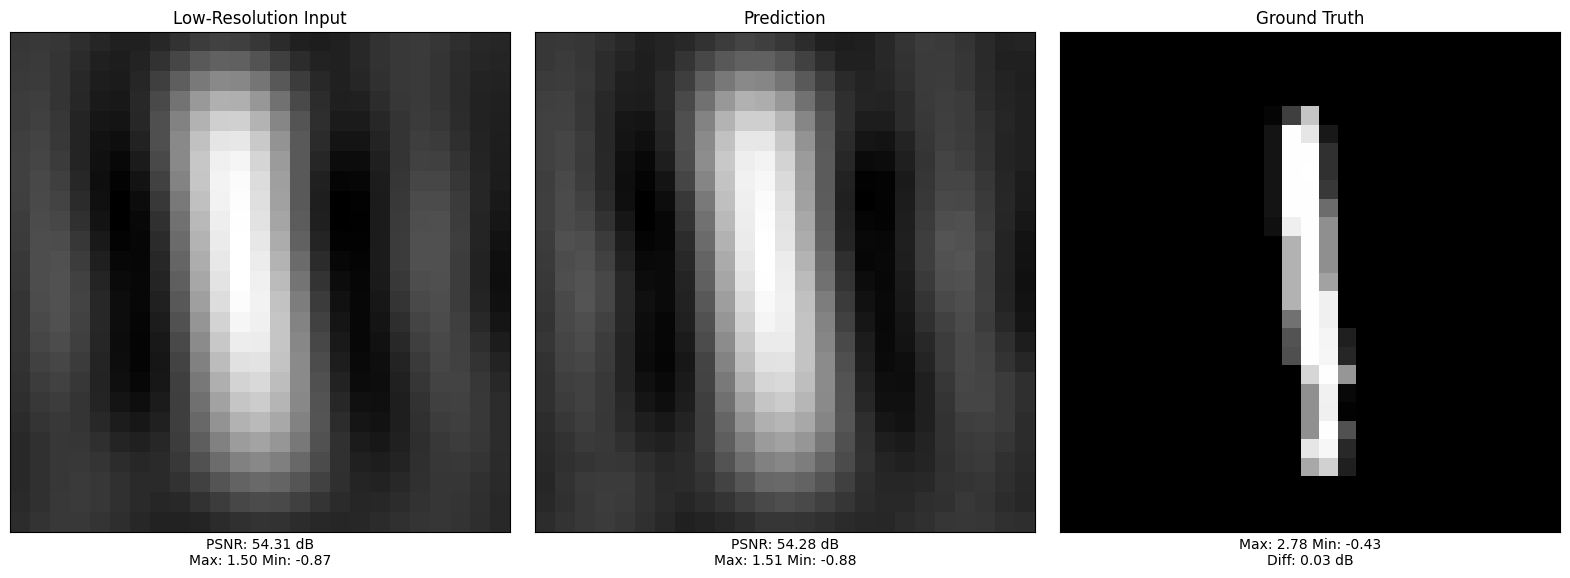

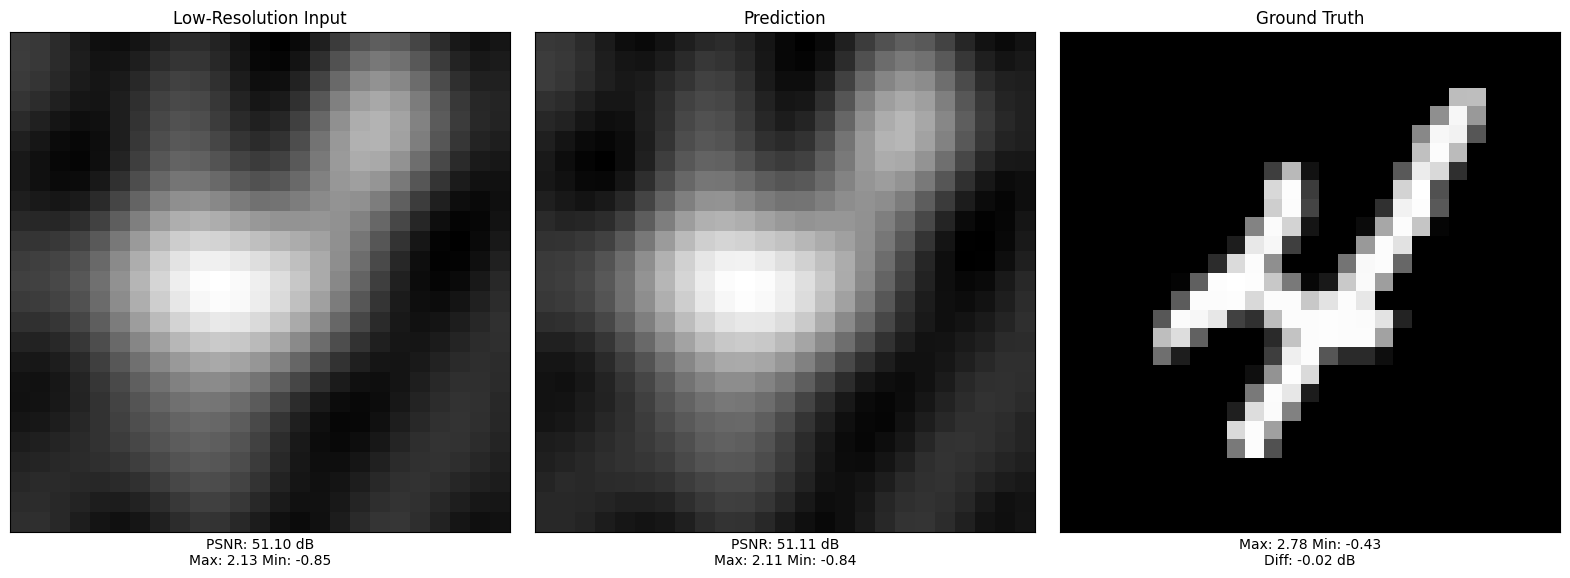

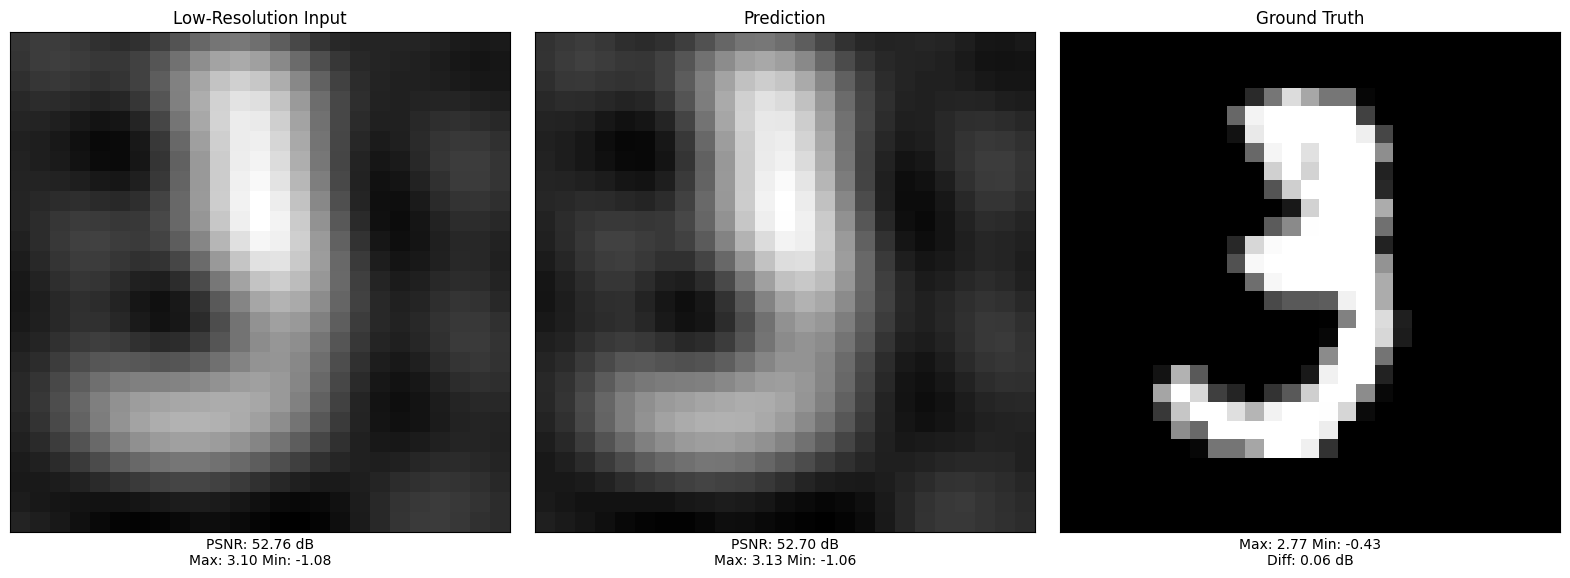

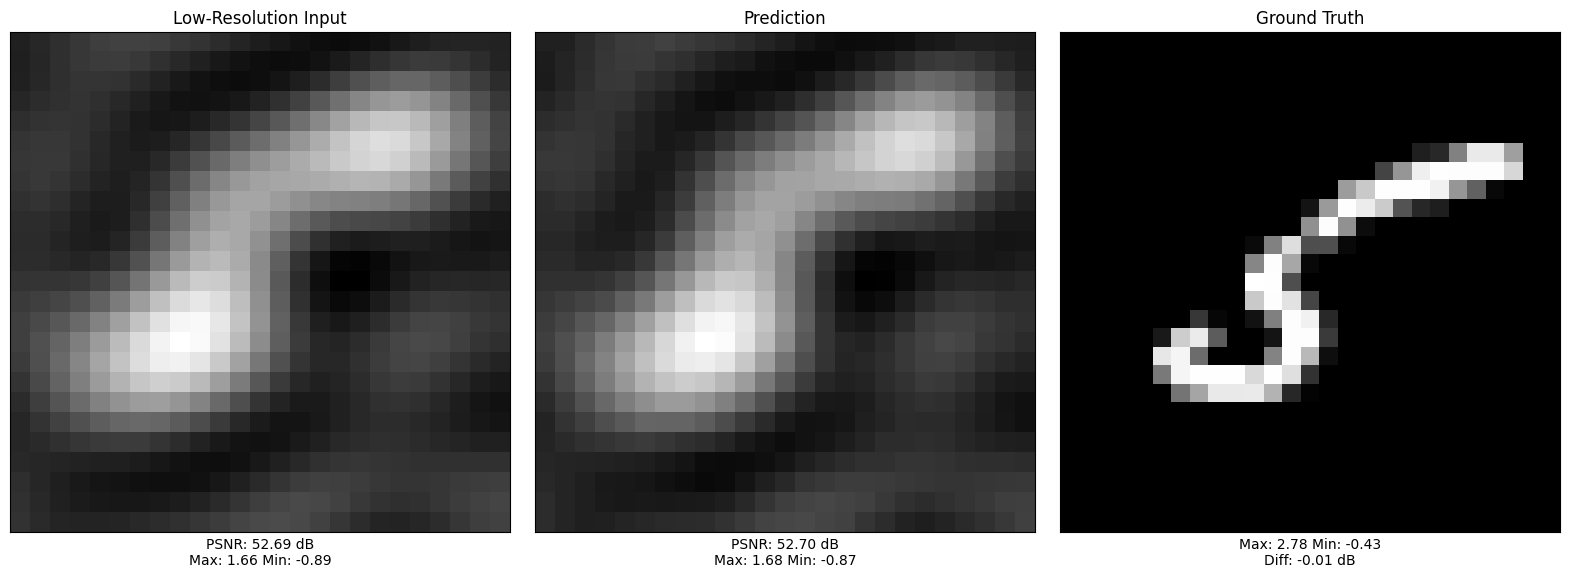

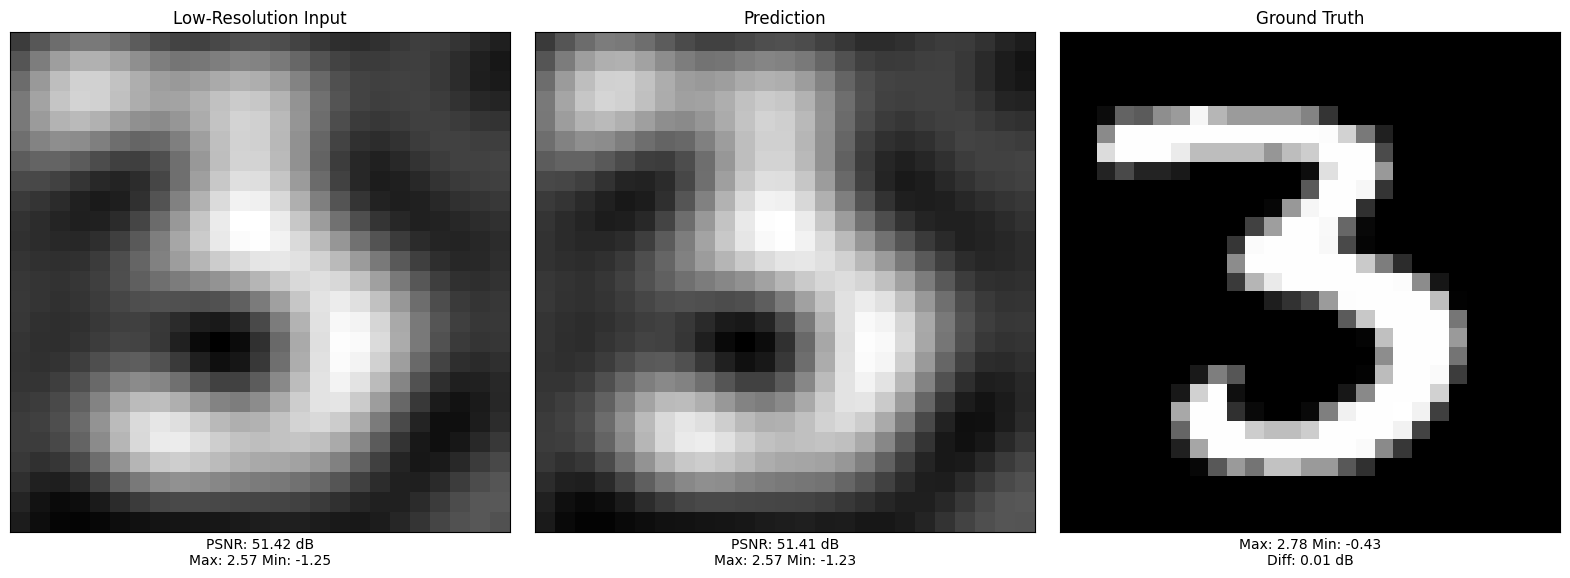

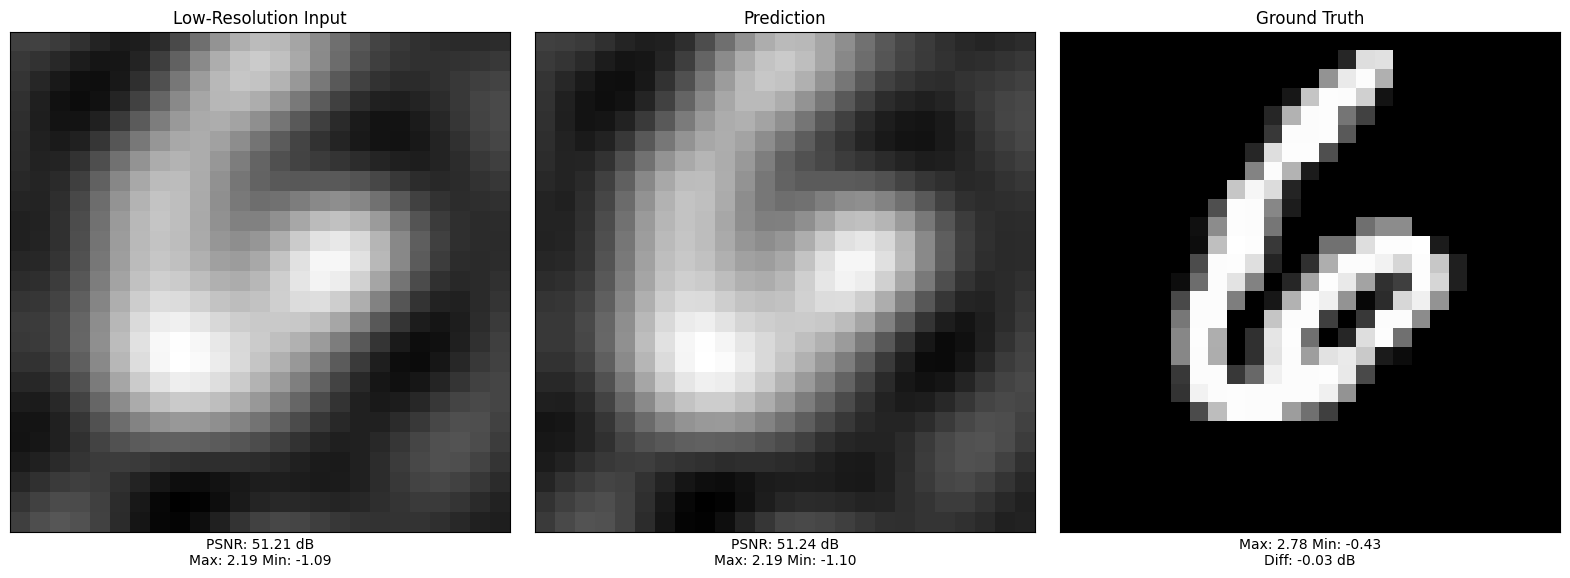

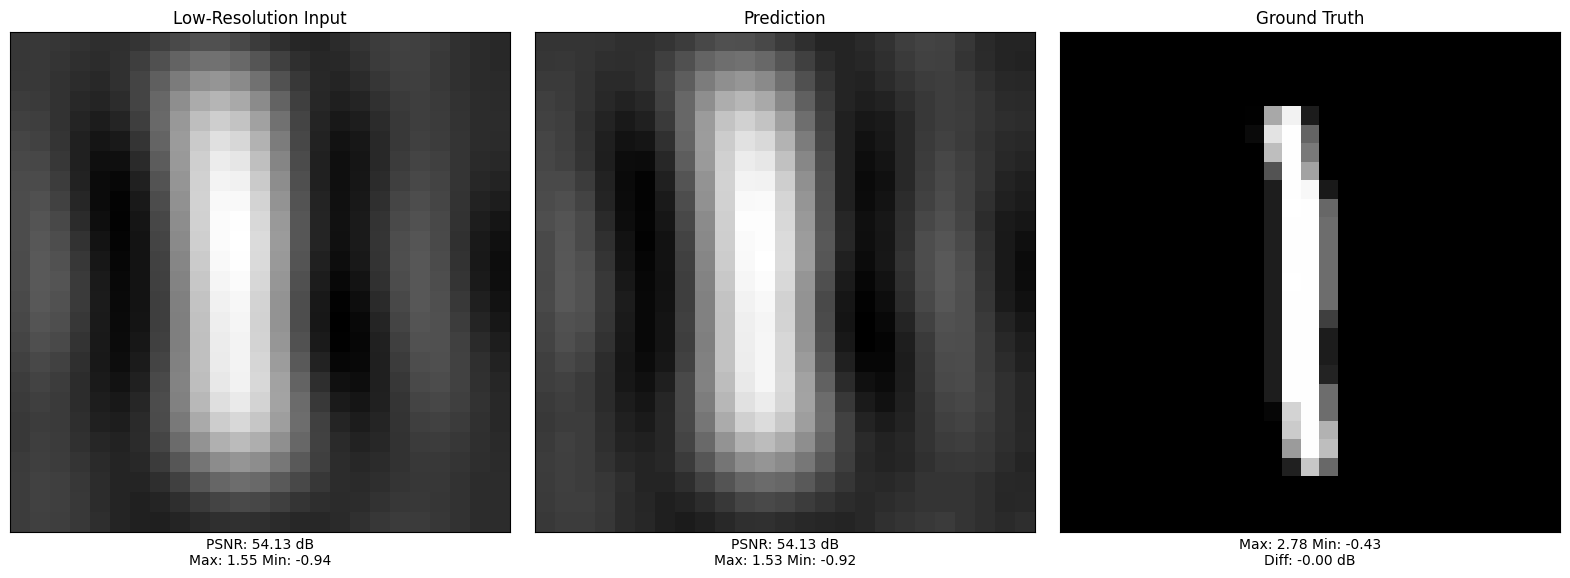

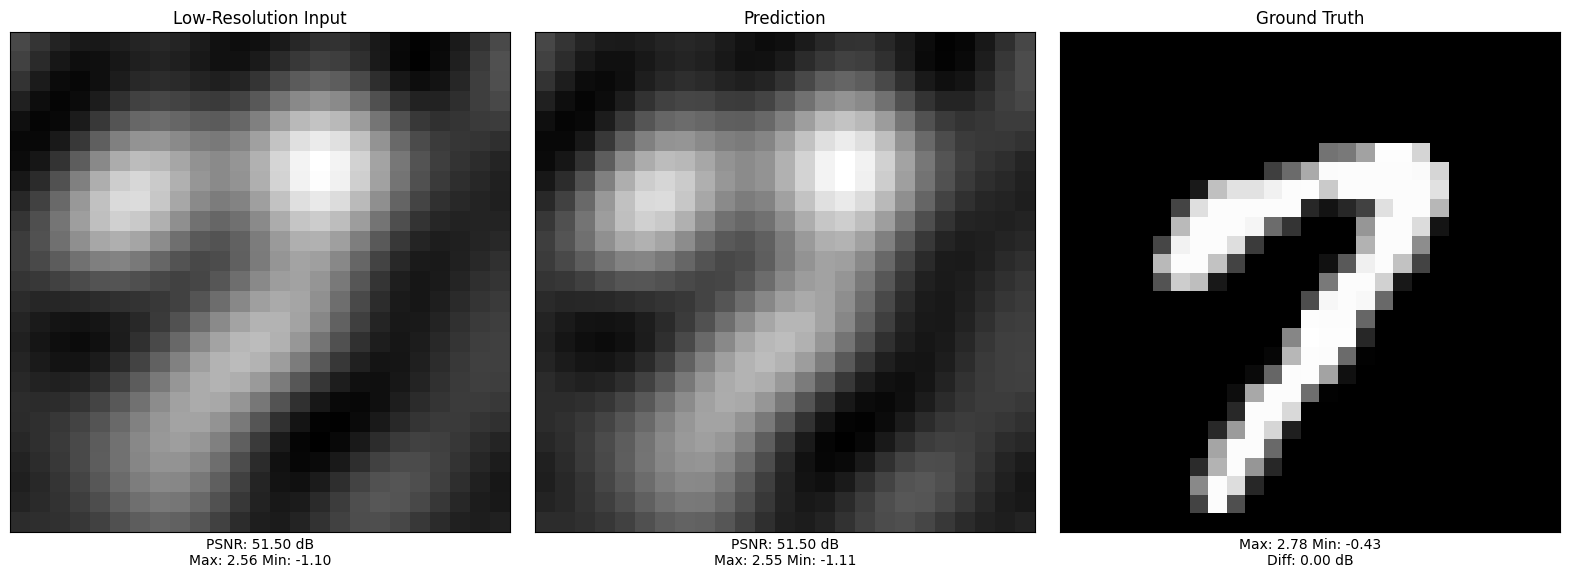

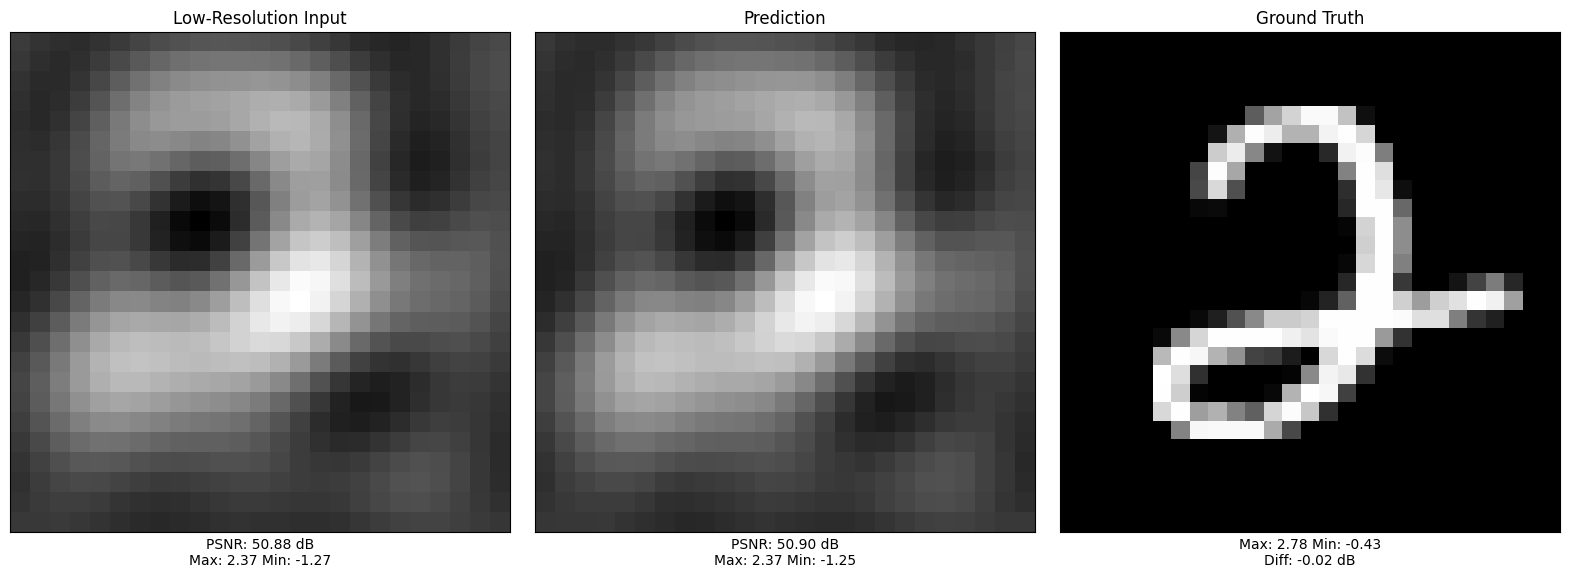

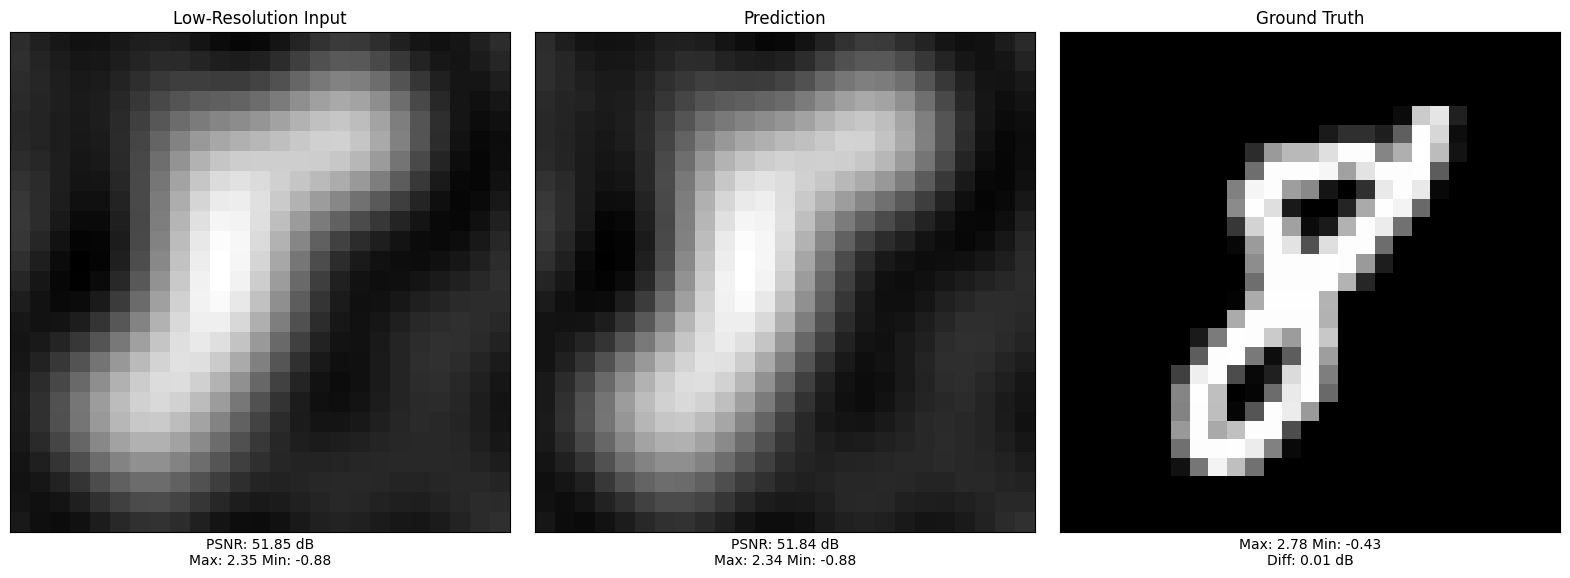

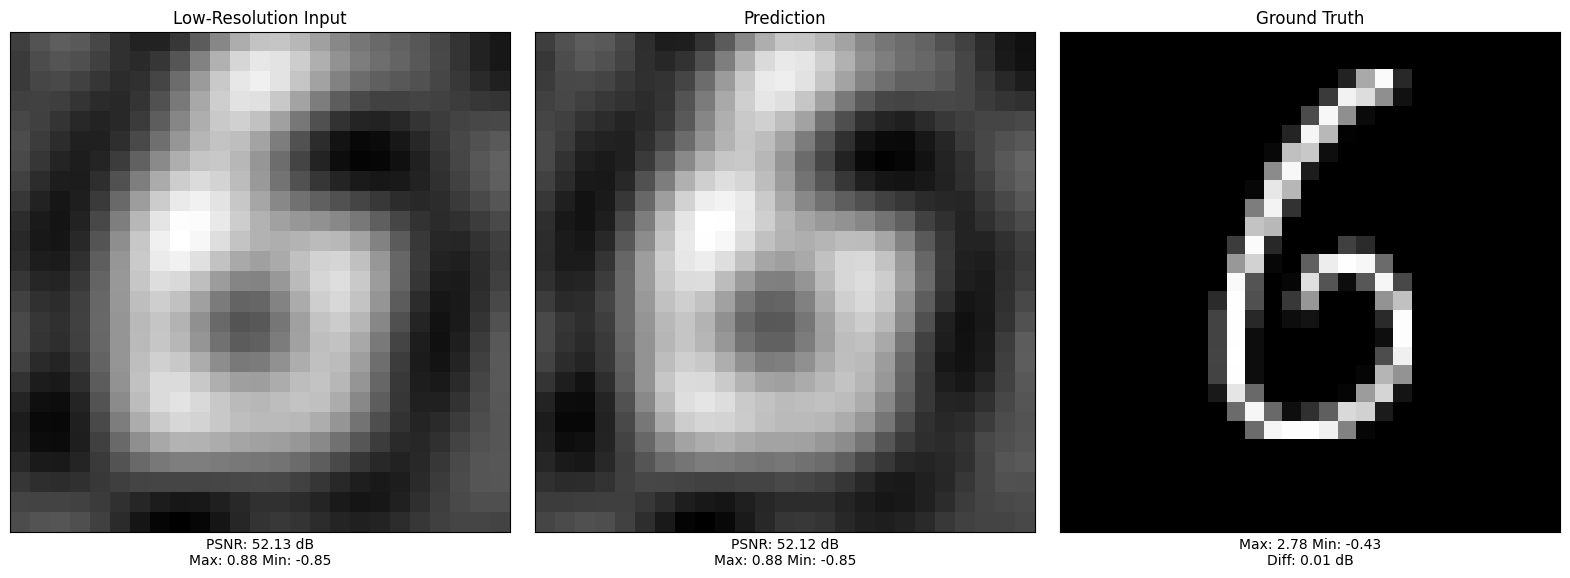

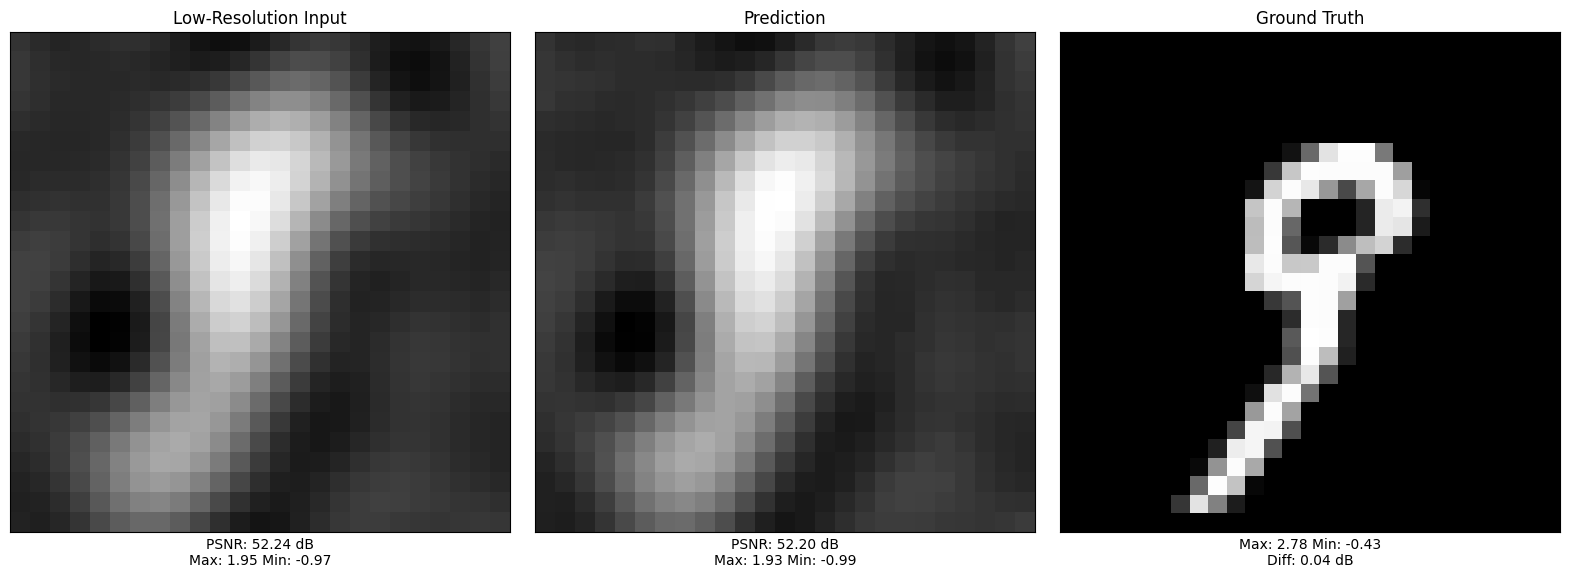

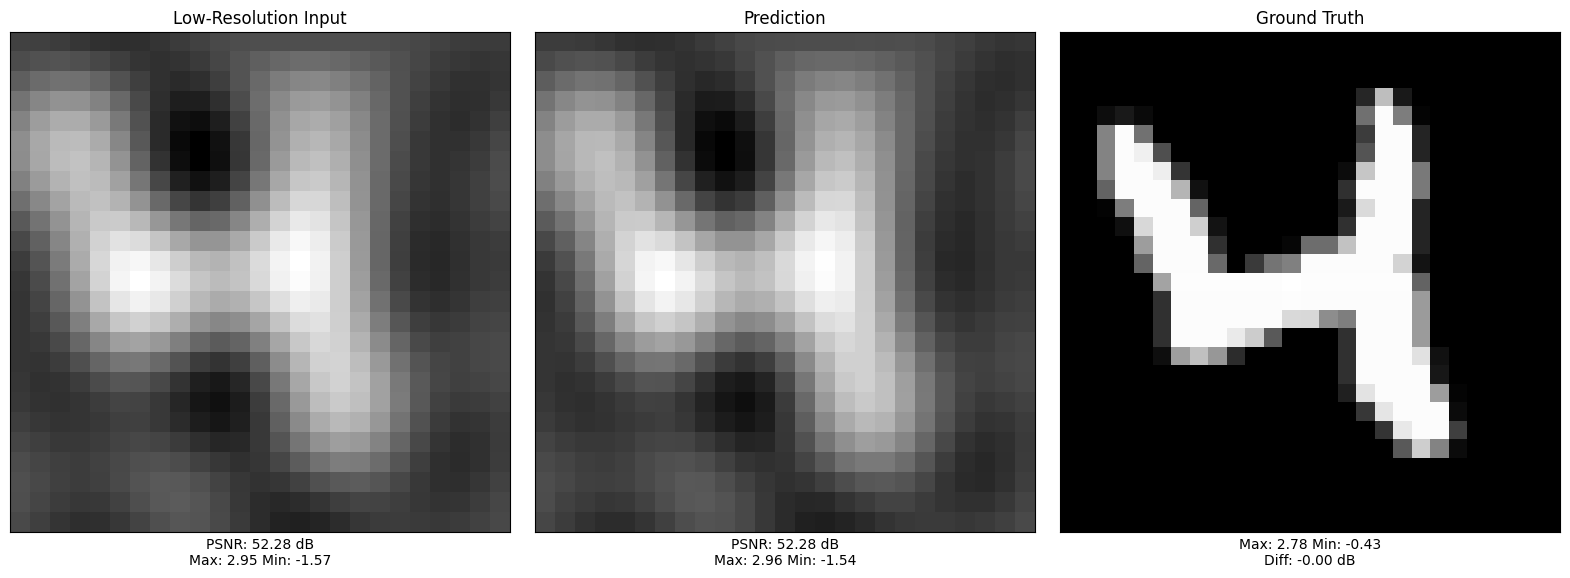

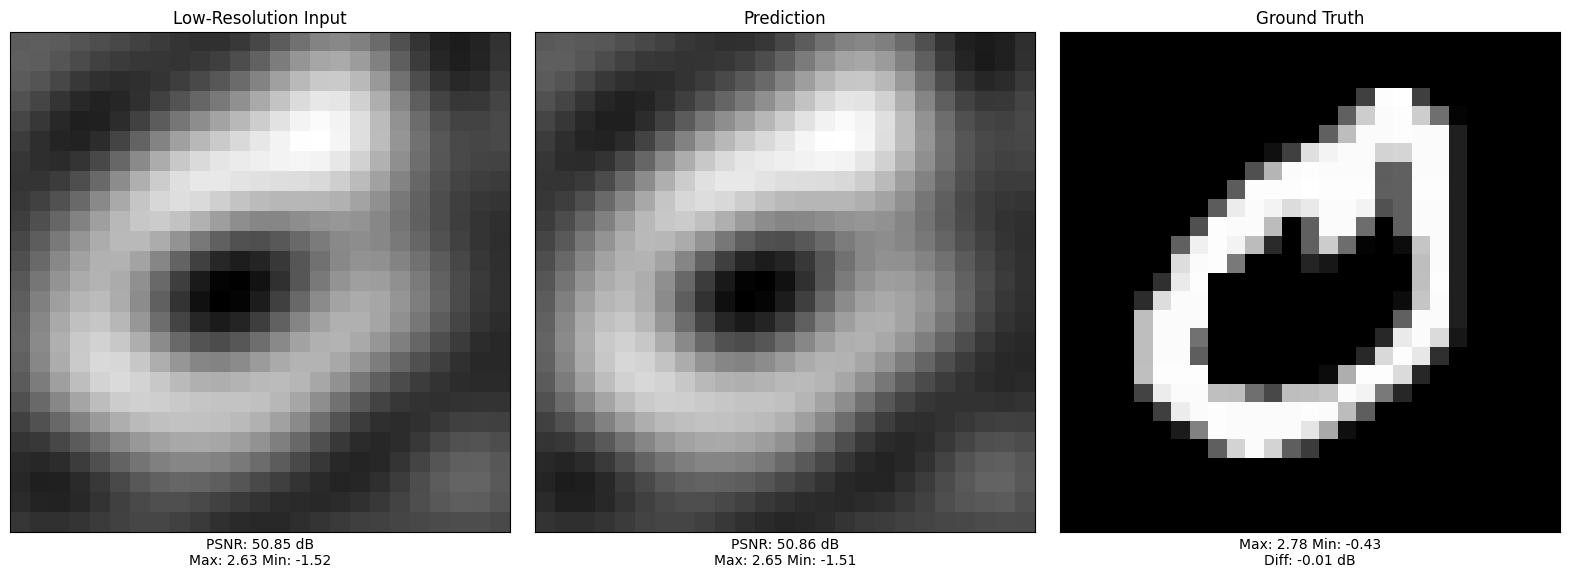

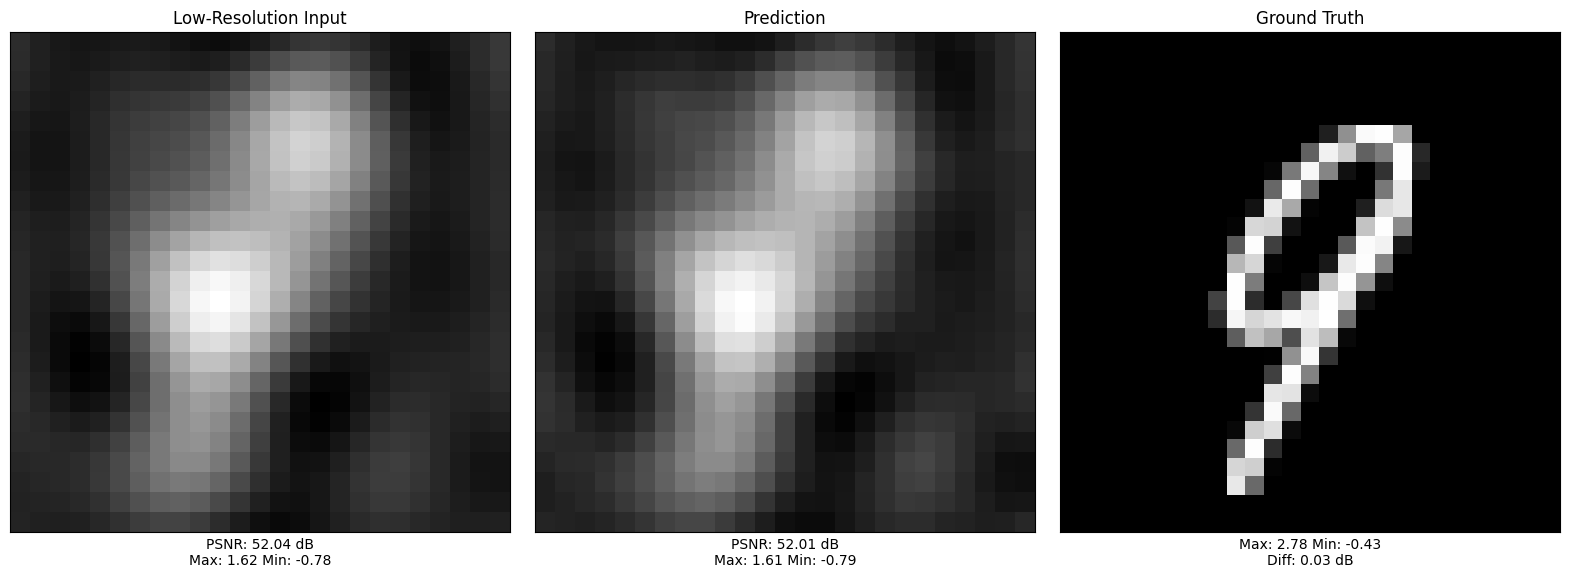

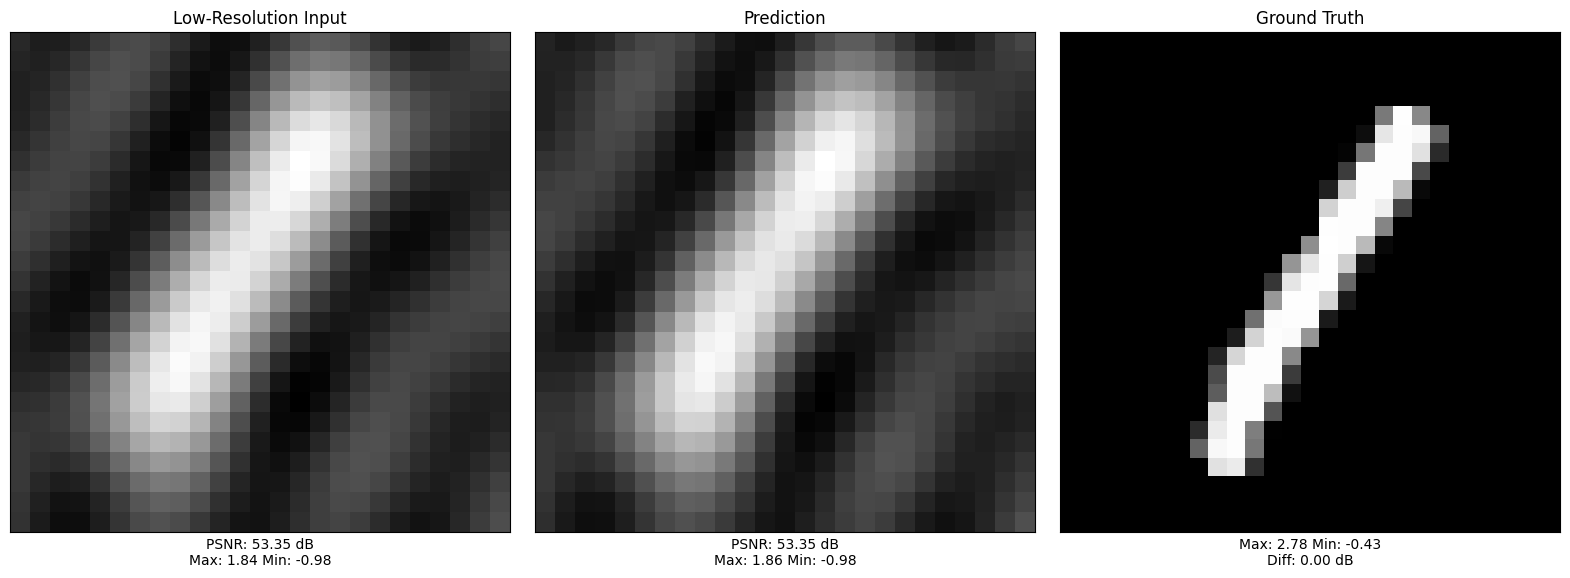

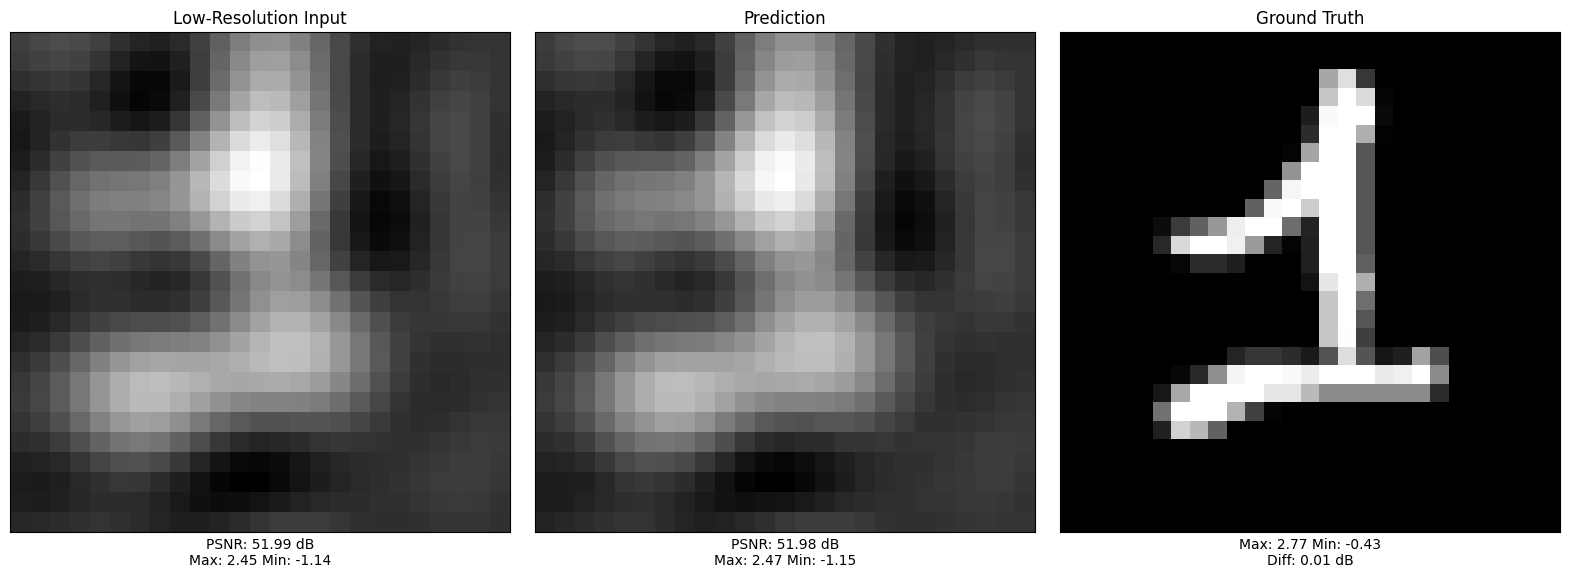

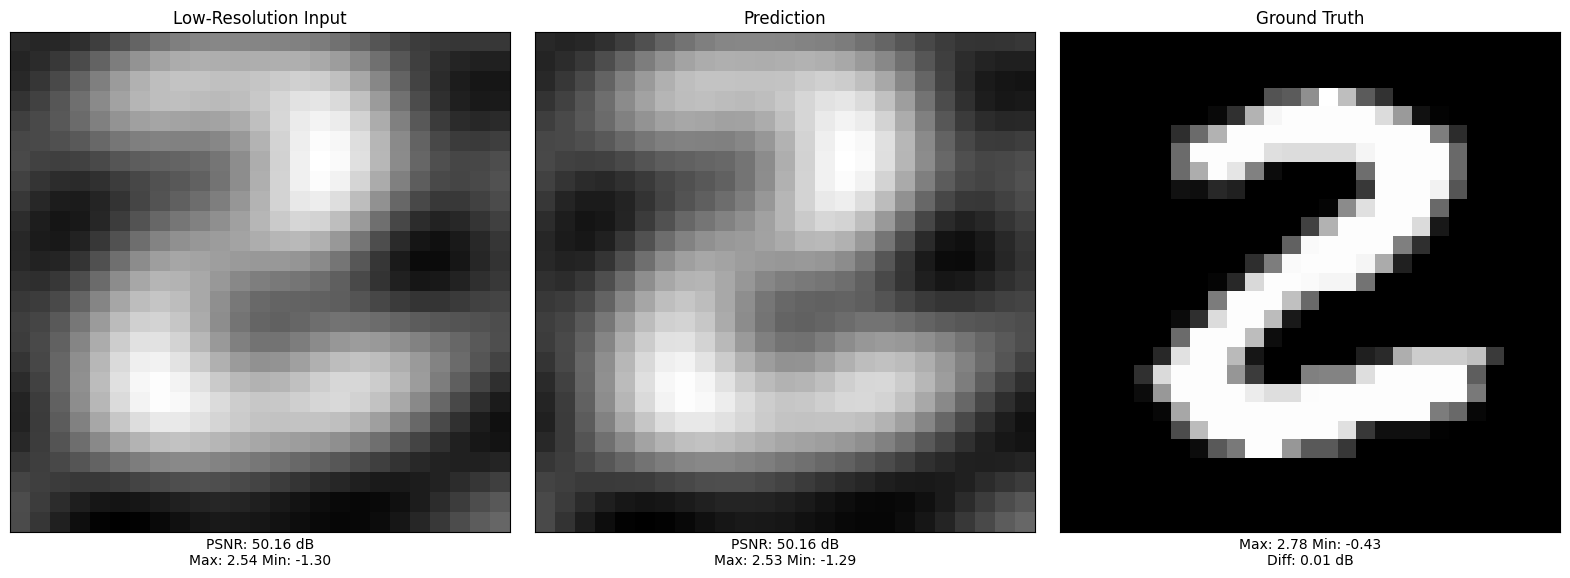

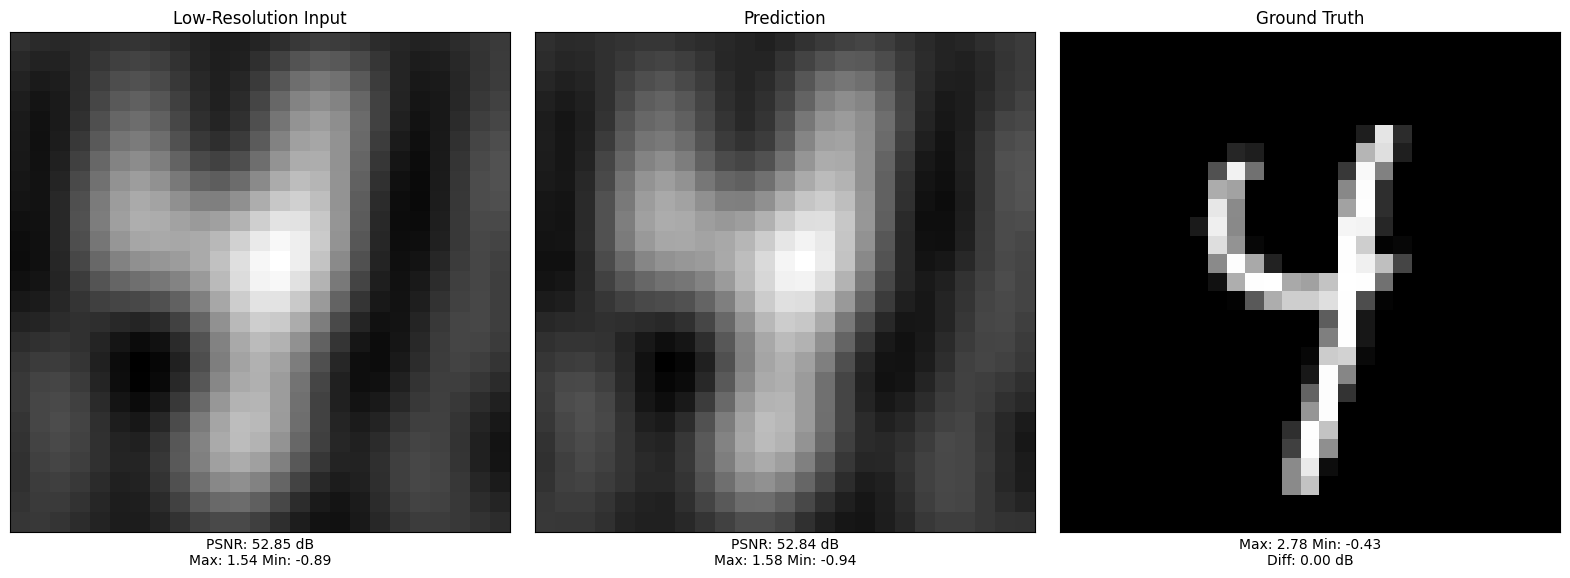

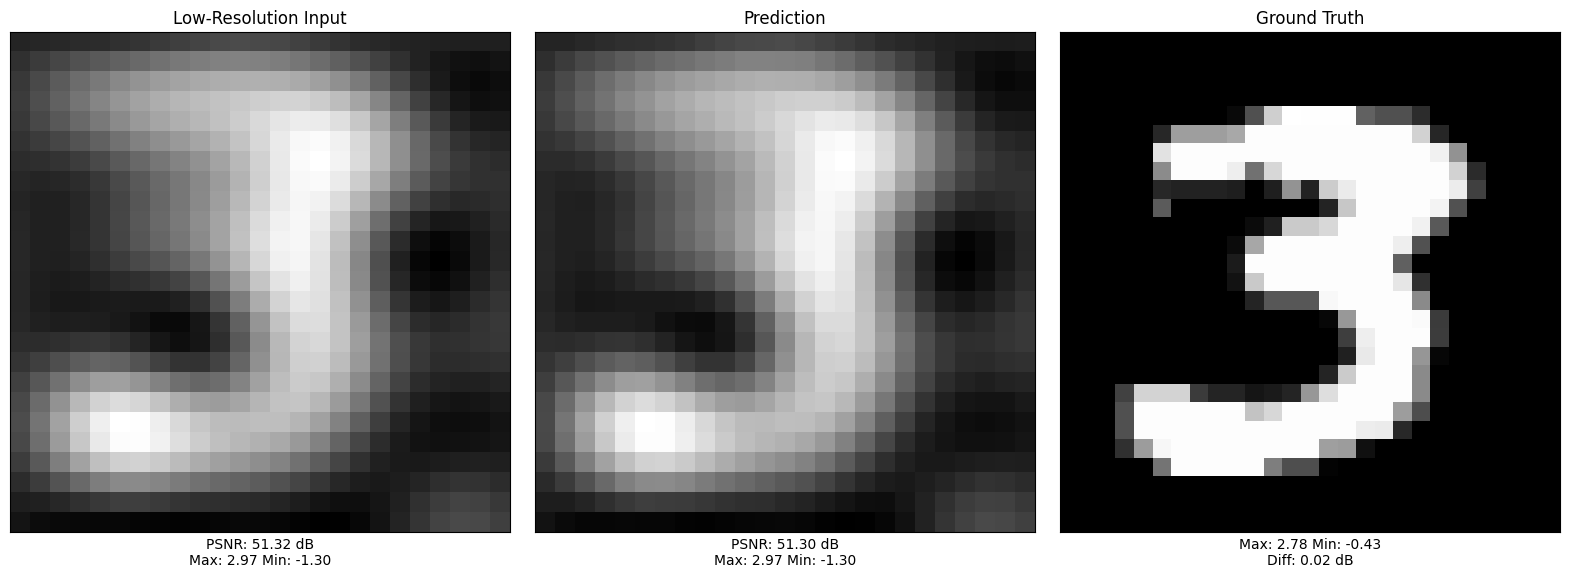

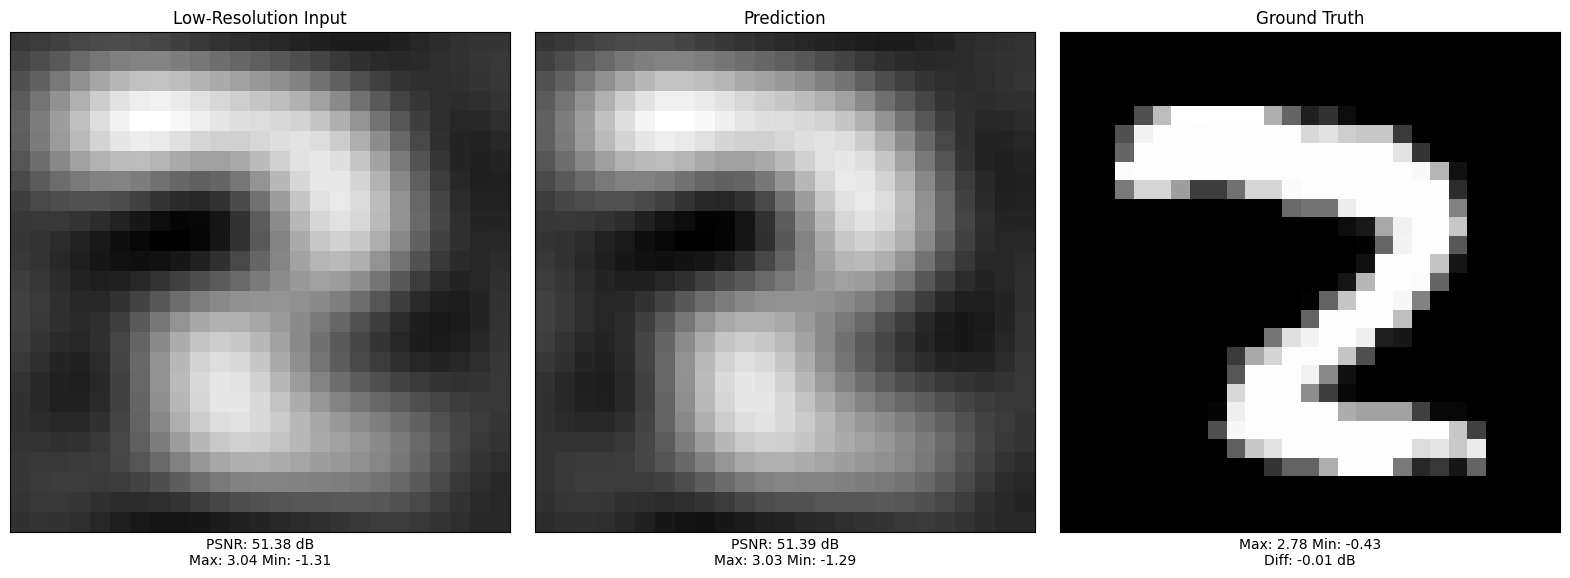

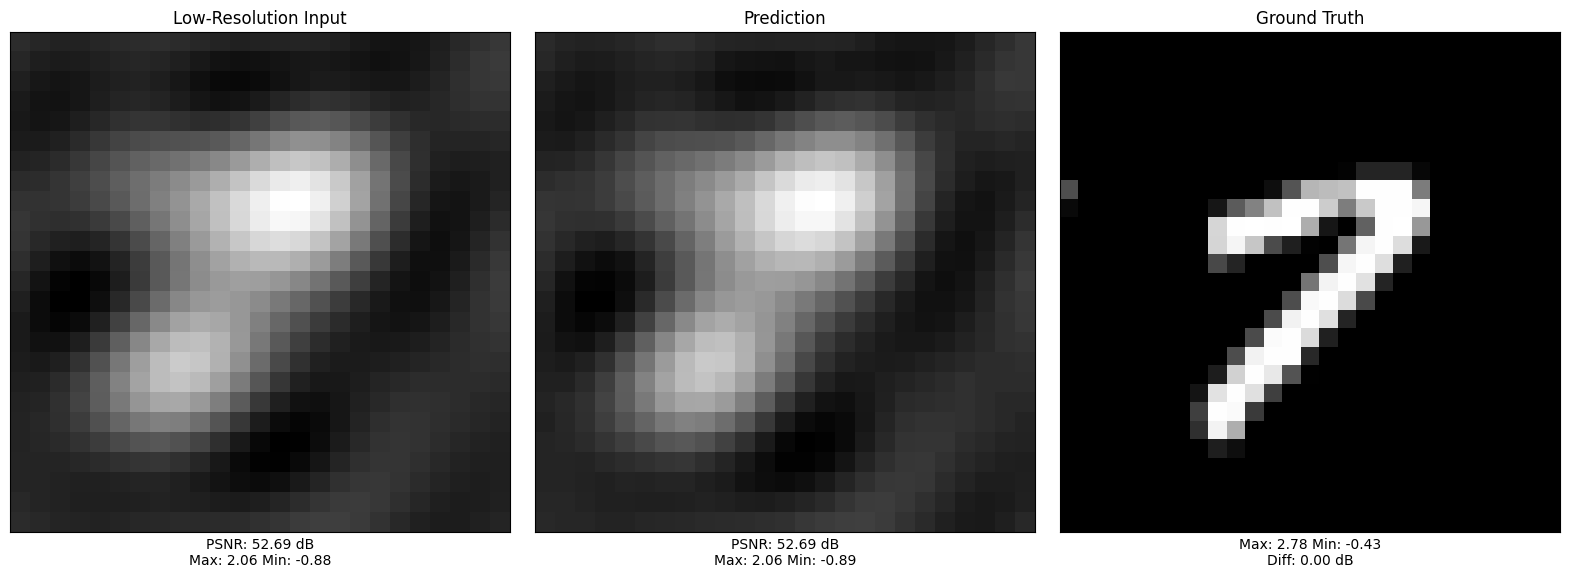

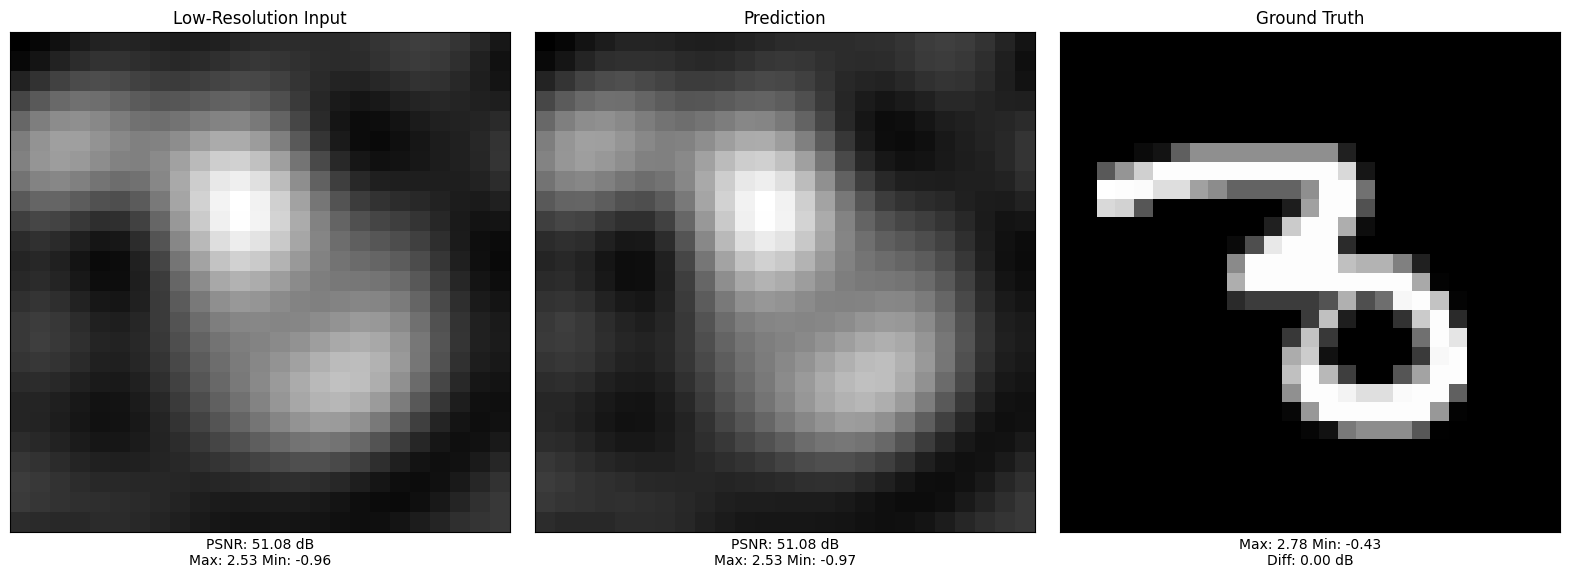

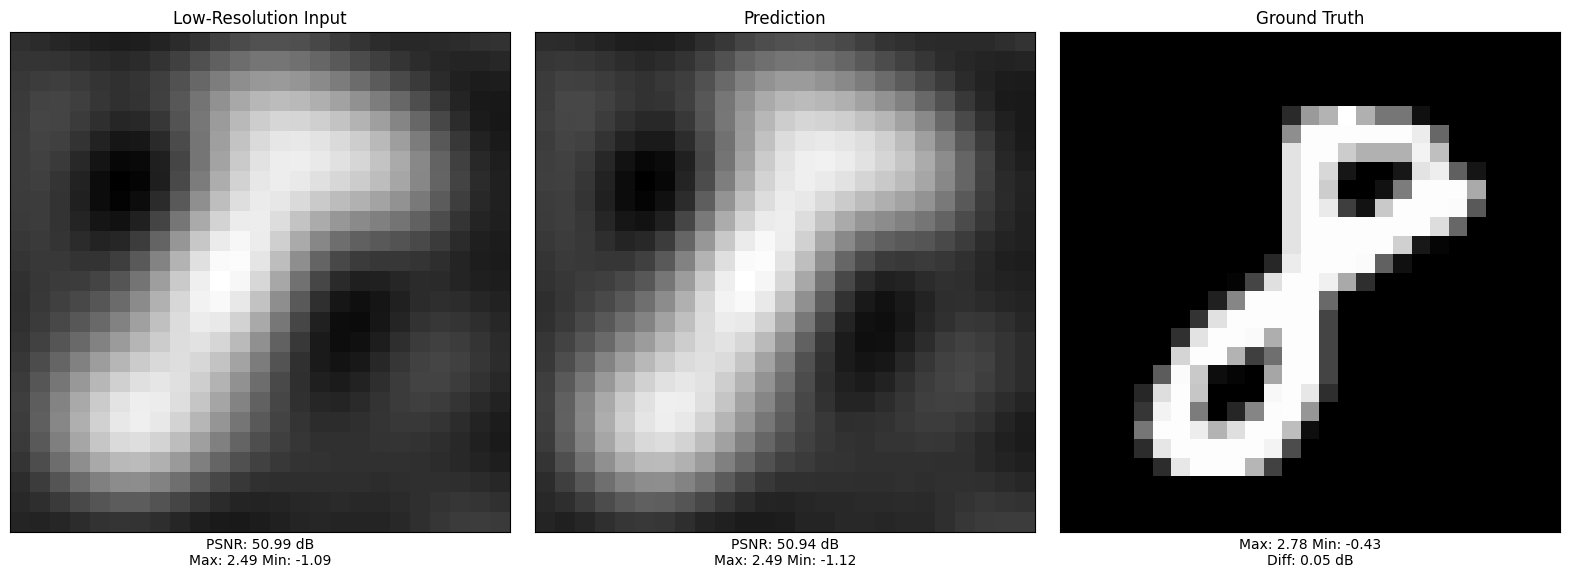

In [11]:
diff = []
for i in range(32):
    sample = i
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_vs_gt_psnr = PSNR(gt[sample][2:, 2:], lowres[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(lowres[sample][2:, 2:], cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_vs_gt_psnr:.2f} dB\nMax: {lowres[sample].max():.2f} Min: {lowres[sample].min():.2f}');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    
    ax1.imshow(pred_img[sample][2:, 2:], cmap='gray')
    pred_vs_gt_psnr = PSNR(gt[sample][2:, 2:], pred_img[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_vs_gt_psnr:.2f} dB\nMax: {pred_img[sample].max():.2f} Min: {pred_img[sample].min():.2f}');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt[sample], cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.set_xlabel(f'Max: {gt[sample].max():.2f} Min: {gt[sample].min():.2f}\nDiff: {lowres_vs_gt_psnr - pred_vs_gt_psnr:.2f} dB');
    ax2.axis('equal');
    diff.append(lowres_vs_gt_psnr - pred_vs_gt_psnr)


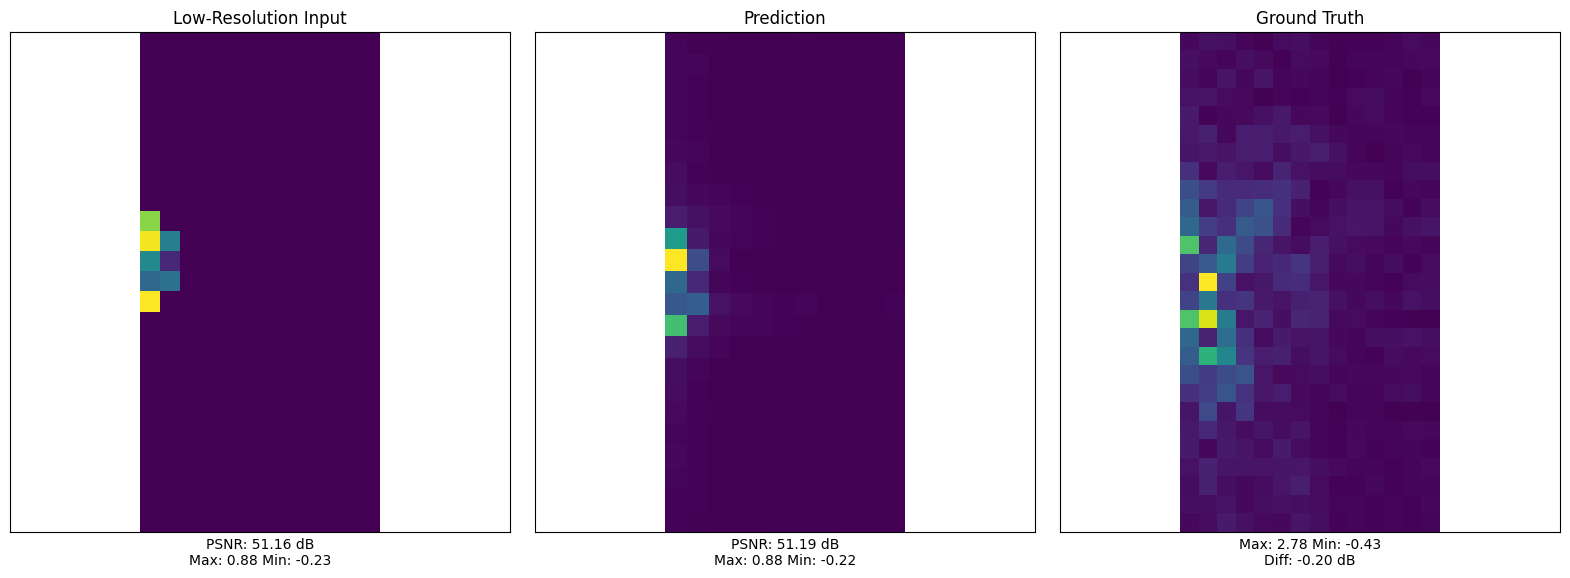

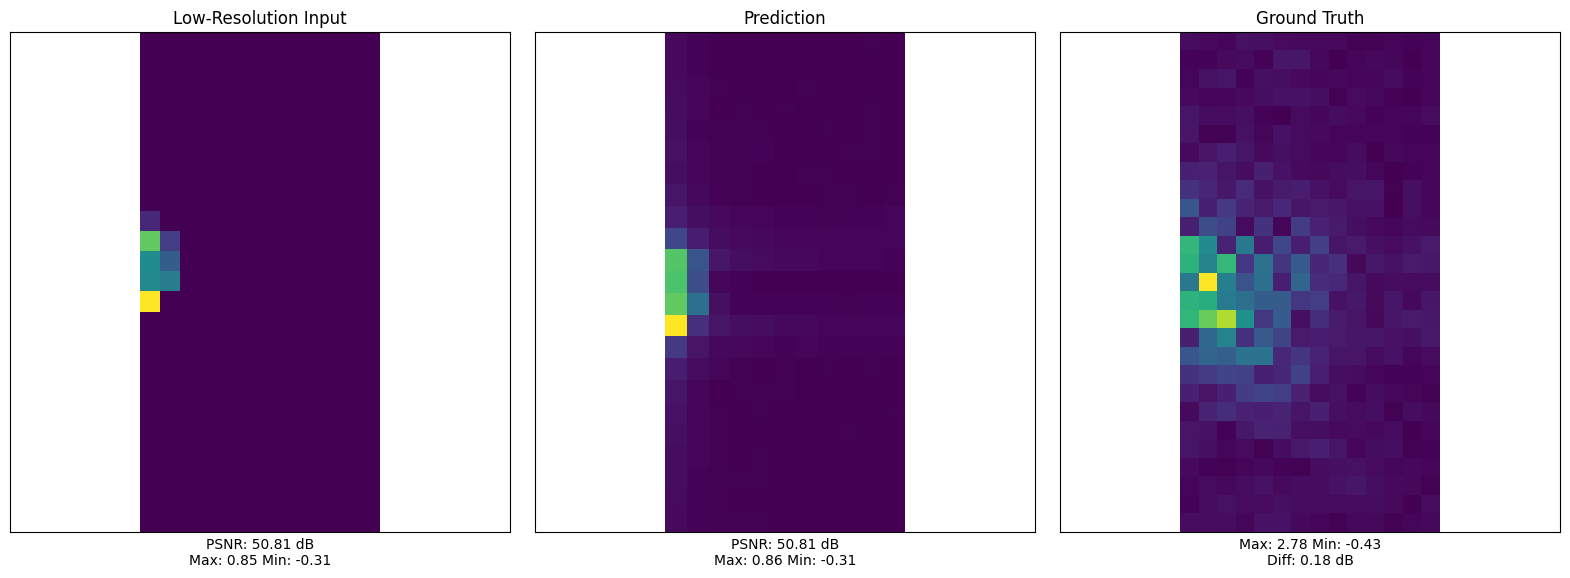

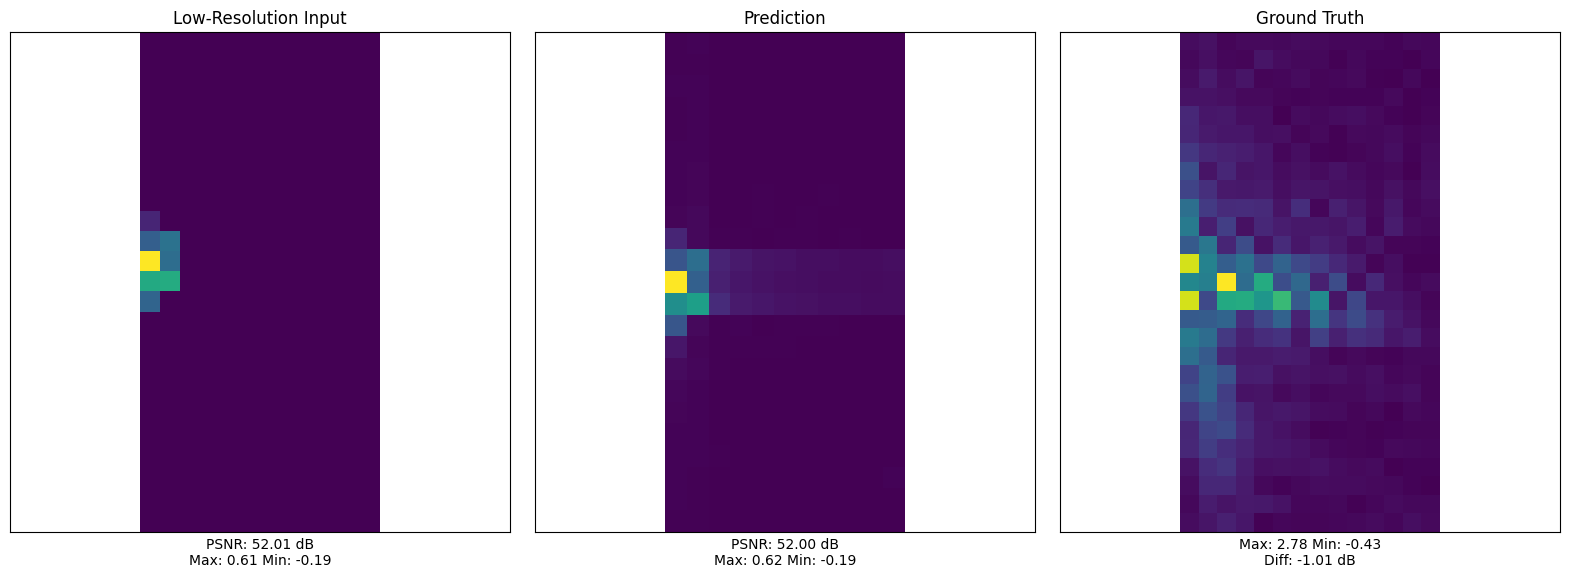

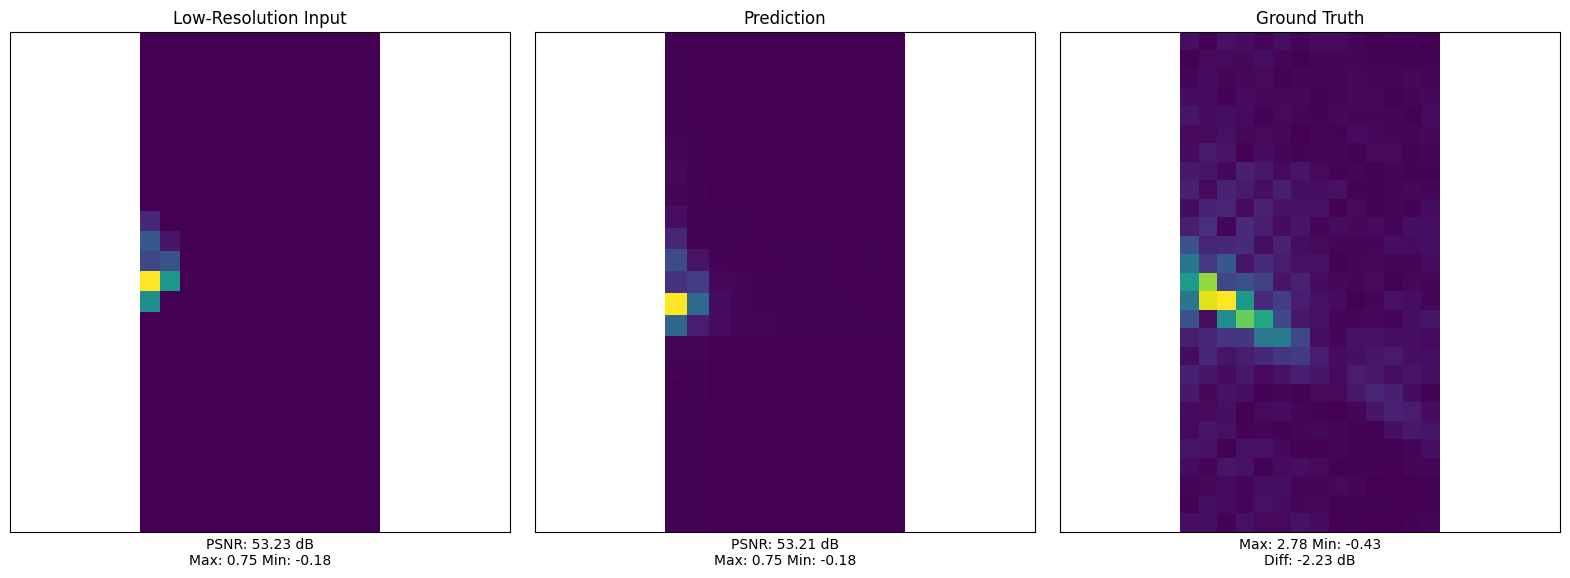

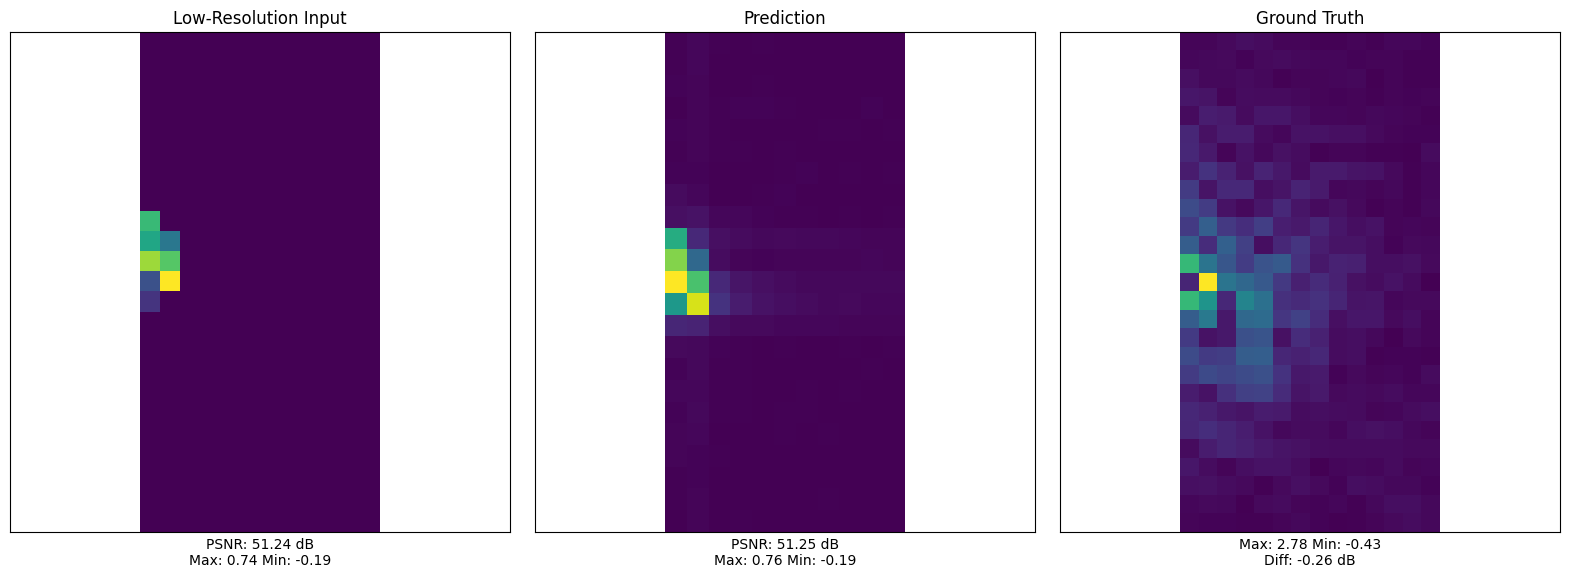

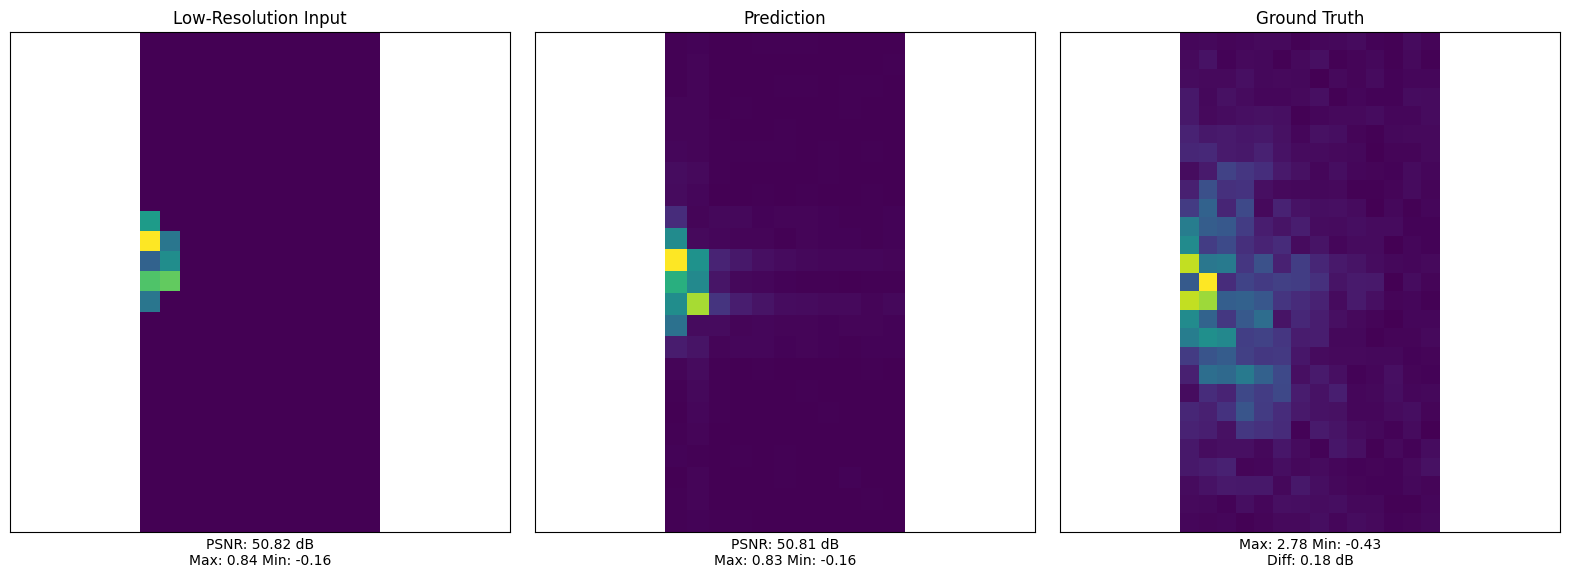

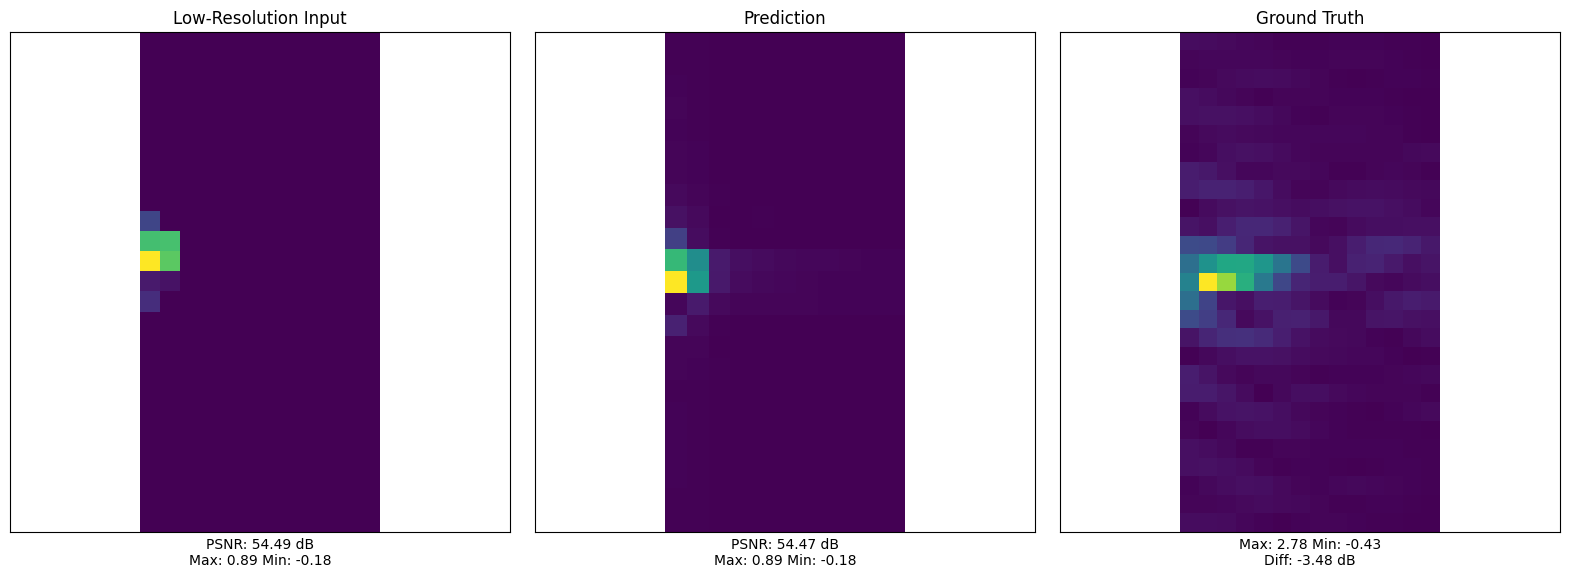

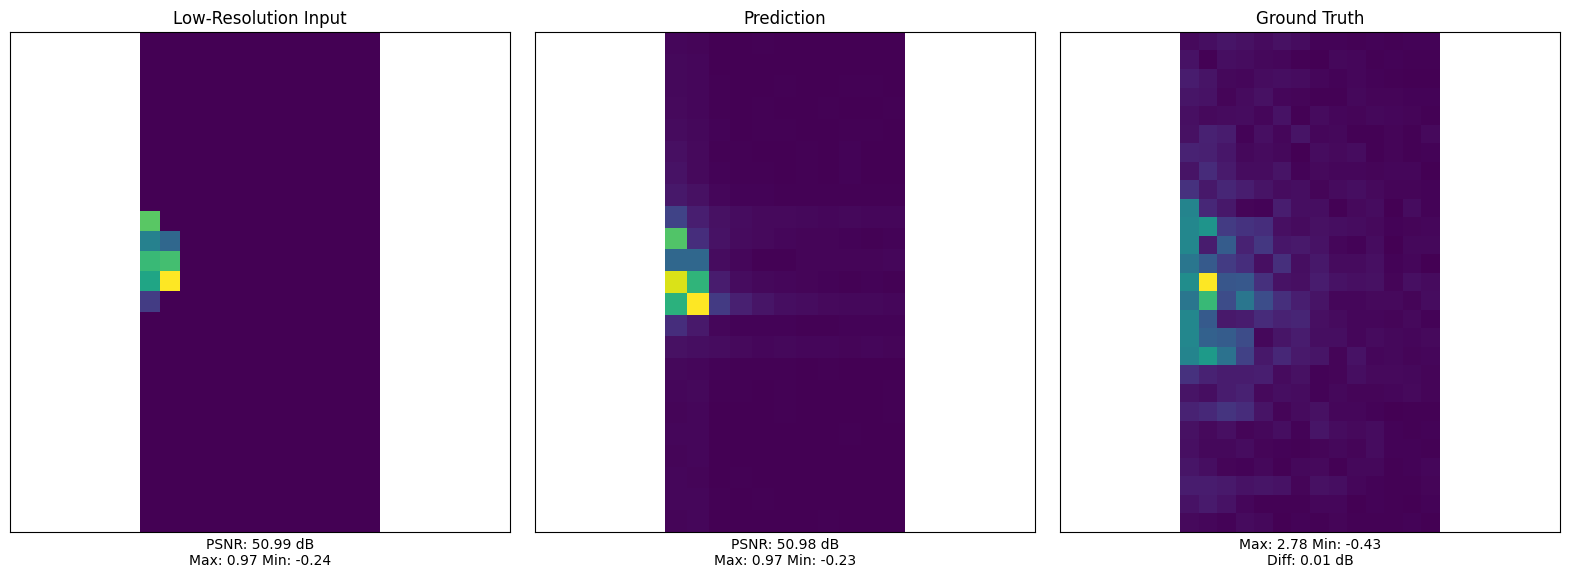

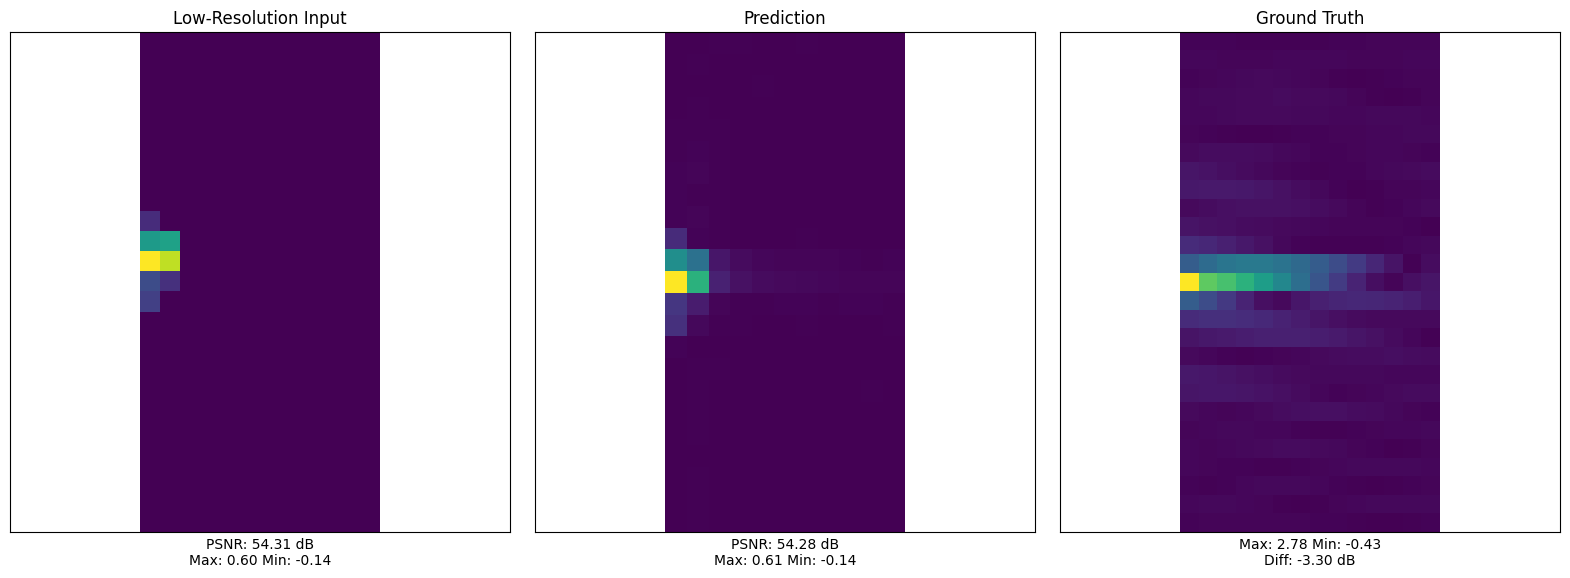

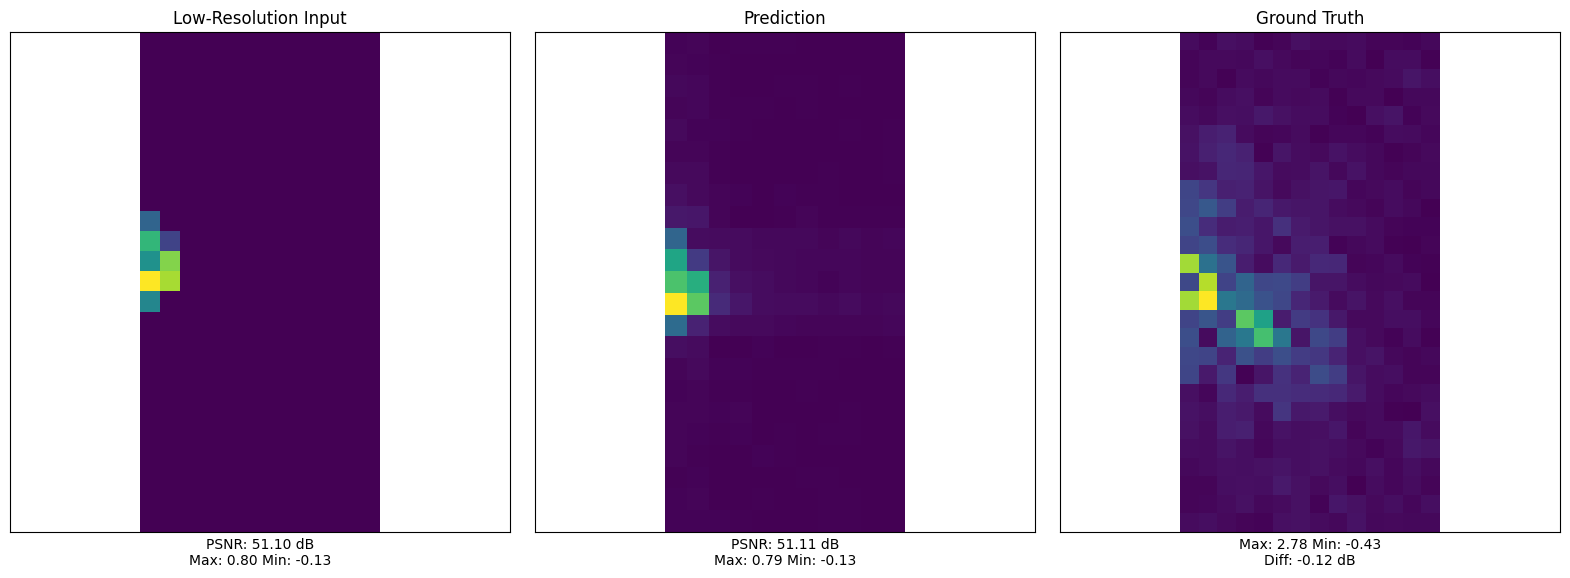

In [12]:
diff = []
lowres_scaled = torch.zeros_like(lowres)
pred_img_scaled = torch.zeros_like(pred_img)
for i in range(10):
    sample = i
    pred_img_scaled[i] = (pred_img[i] - gt[i].min())/(gt[i].max() - gt[i].min())
    lowres_scaled[i] = (lowres[i] - gt[i].min())/(gt[i].max() - gt[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_scaled_vs_gt_psnr = PSNR(gt[sample][2:, 2:], lowres_scaled[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres[sample],dim = [0,1])),13,0)[2:, 2:])
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_scaled_vs_gt_psnr:.2f} dB\nMax: {lowres_scaled[sample].max():.2f} Min: {lowres_scaled[sample].min():.2f}');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample][2:, 2:],dim = [0,1])),13,0)[2:, 2:])
    pred_vs_gt_psnr = PSNR(gt[sample][2:, 2:], pred_img_scaled[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_vs_gt_psnr:.2f} dB\nMax: {pred_img_scaled[sample].max():.2f} Min: {pred_img_scaled[sample].min():.2f}');
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt[sample],dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    ax2.set_xlabel(f'Max: {gt[sample].max():.2f} Min: {gt[sample].min():.2f}\nDiff: {lowres_vs_gt_psnr - pred_vs_gt_psnr:.2f} dB');
    ax2.axis('equal');
    diff.append(lowres_vs_gt_psnr - pred_vs_gt_psnr)

